In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy import stats
from scipy.stats import zscore
import itertools
import re
import matplotlib.pyplot as plt
import seaborn as sns
import helper

In [2]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
isu_pal = [
    "#FF0B04", "#9A3324", "#B9975B", "#707372", "#F1BE48",
    "#FF0B04", "#9A3324", "#B9975B", "#707372", "#F1BE48",
    "#FF0B04", "#9A3324", "#B9975B", "#707372", "#F1BE48",
    "#FF0B04", "#9A3324", "#B9975B", "#707372", "#F1BE48",
    "#FF0B04", "#9A3324", "#B9975B", "#707372", "#F1BE48",
    "#FF0B04", "#9A3324", "#B9975B", "#707372", "#F1BE48"
]
sns.set_theme()
sns.set_context('notebook')
sns.set_palette(sns.color_palette(isu_pal))

In [3]:
reg = linear_model.LinearRegression()

In [4]:
hous_all = pd.read_csv('all.csv', index_col=0, low_memory=False)

In [5]:
hous_all['SaleCondition'].value_counts()

Normal     2414
Partial      82
Abnorml      61
Family       17
Alloca        4
AdjLand       2
Name: SaleCondition, dtype: int64

In [6]:
# Exclude everything except where 'SaleCondition' is 'Normal' or 'Partial'.
hous_all = hous_all[(hous_all['SaleCondition'] == 'Normal') | (hous_all['SaleCondition'] == 'Partial')]

In [7]:
hous_all['SaleCondition'].value_counts()

Normal     2414
Partial      82
Name: SaleCondition, dtype: int64

In [8]:
# Perform the split using stratified sampling based on 'Neighborhood'.
hous_trn, hous_tst = helper.stratified_split(hous_all, 'Neighborhood')

In [9]:
print(hous_trn.shape)
print(hous_tst.shape)

(1871, 81)
(624, 81)


In [10]:
myvar_dict = {'Lot':['LotFrontage', 'LotArea', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope'], 
         'Neighborhood':['Neighborhood'],
          'Basement':['Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 
                   'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'],
         'Bedroom':['BedroomAbvGr'],
         'Porch':['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']
         }

In [11]:
myvar = list(itertools.chain(*myvar_dict.values()))

In [12]:
# Columns from my_vars with missing values.
cols_na = hous_trn[myvar].loc[:,hous_trn[myvar].isna().any(axis=0)].columns.to_list()
cols_na

['LotFrontage',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'BsmtFullBath',
 'BsmtHalfBath']

In [13]:
hous_trn['MSSubClass'].unique()

array([ 90, 160,  50,  85,  60,  75,  20,  70,  30,  80, 190, 120,  45,
        40, 150, 180], dtype=int64)

In [60]:
# Change dtypes of those my_vars that need it.
# Note the use of 'Int64' as opposed to 'int64' when there are NaNs present.
hous_trn = hous_trn.astype({'LotArea':'float64', 'LotShape':'string', 
                 'LandContour':'string', 'LotConfig':'string',
                 'LandSlope':'string', 'Neighborhood':'string',
                 'Foundation':'string', 'BsmtQual':'string',
                 'BsmtCond':'string', 'BsmtExposure':'string', 
                 'BsmtFinType1':'string', 'BsmtFinType2':'string',
                 'BsmtFullBath':'Int64', 'BsmtHalfBath':'Int64',
                 'WoodDeckSF':'float64', 'OpenPorchSF':'float64',
                 'EnclosedPorch':'float64', '3SsnPorch':'float64',
                 'ScreenPorch':'float64'})

# Investigation of 'Neighborhood'

In [30]:
nhd_ord = hous_trn.groupby('Neighborhood').median().sort_values('SalePrice').index.to_list()

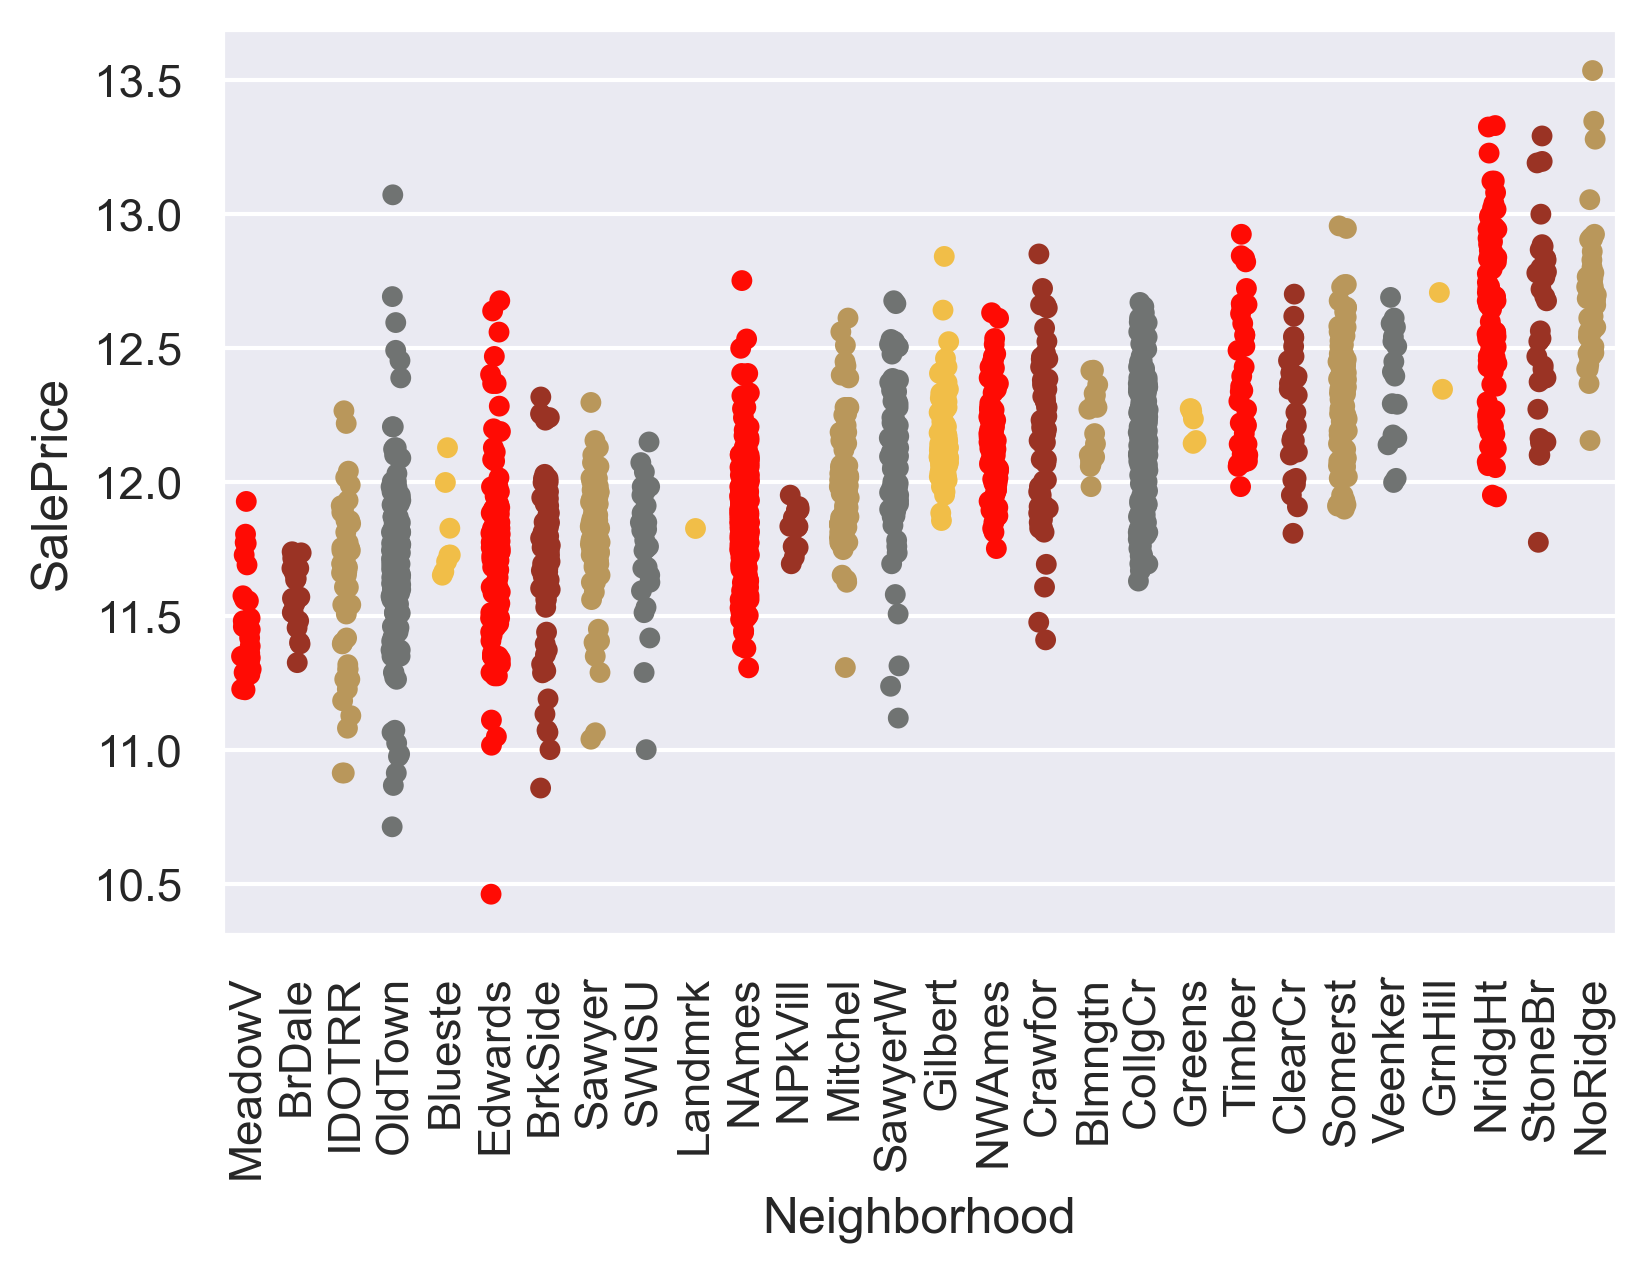

In [31]:
x = hous_trn['Neighborhood']
y = np.log(hous_trn['SalePrice'])
_ = sns.stripplot(x=x, y=y, order=nhd_ord)
_.tick_params(axis='x', rotation=90)
plt.show()

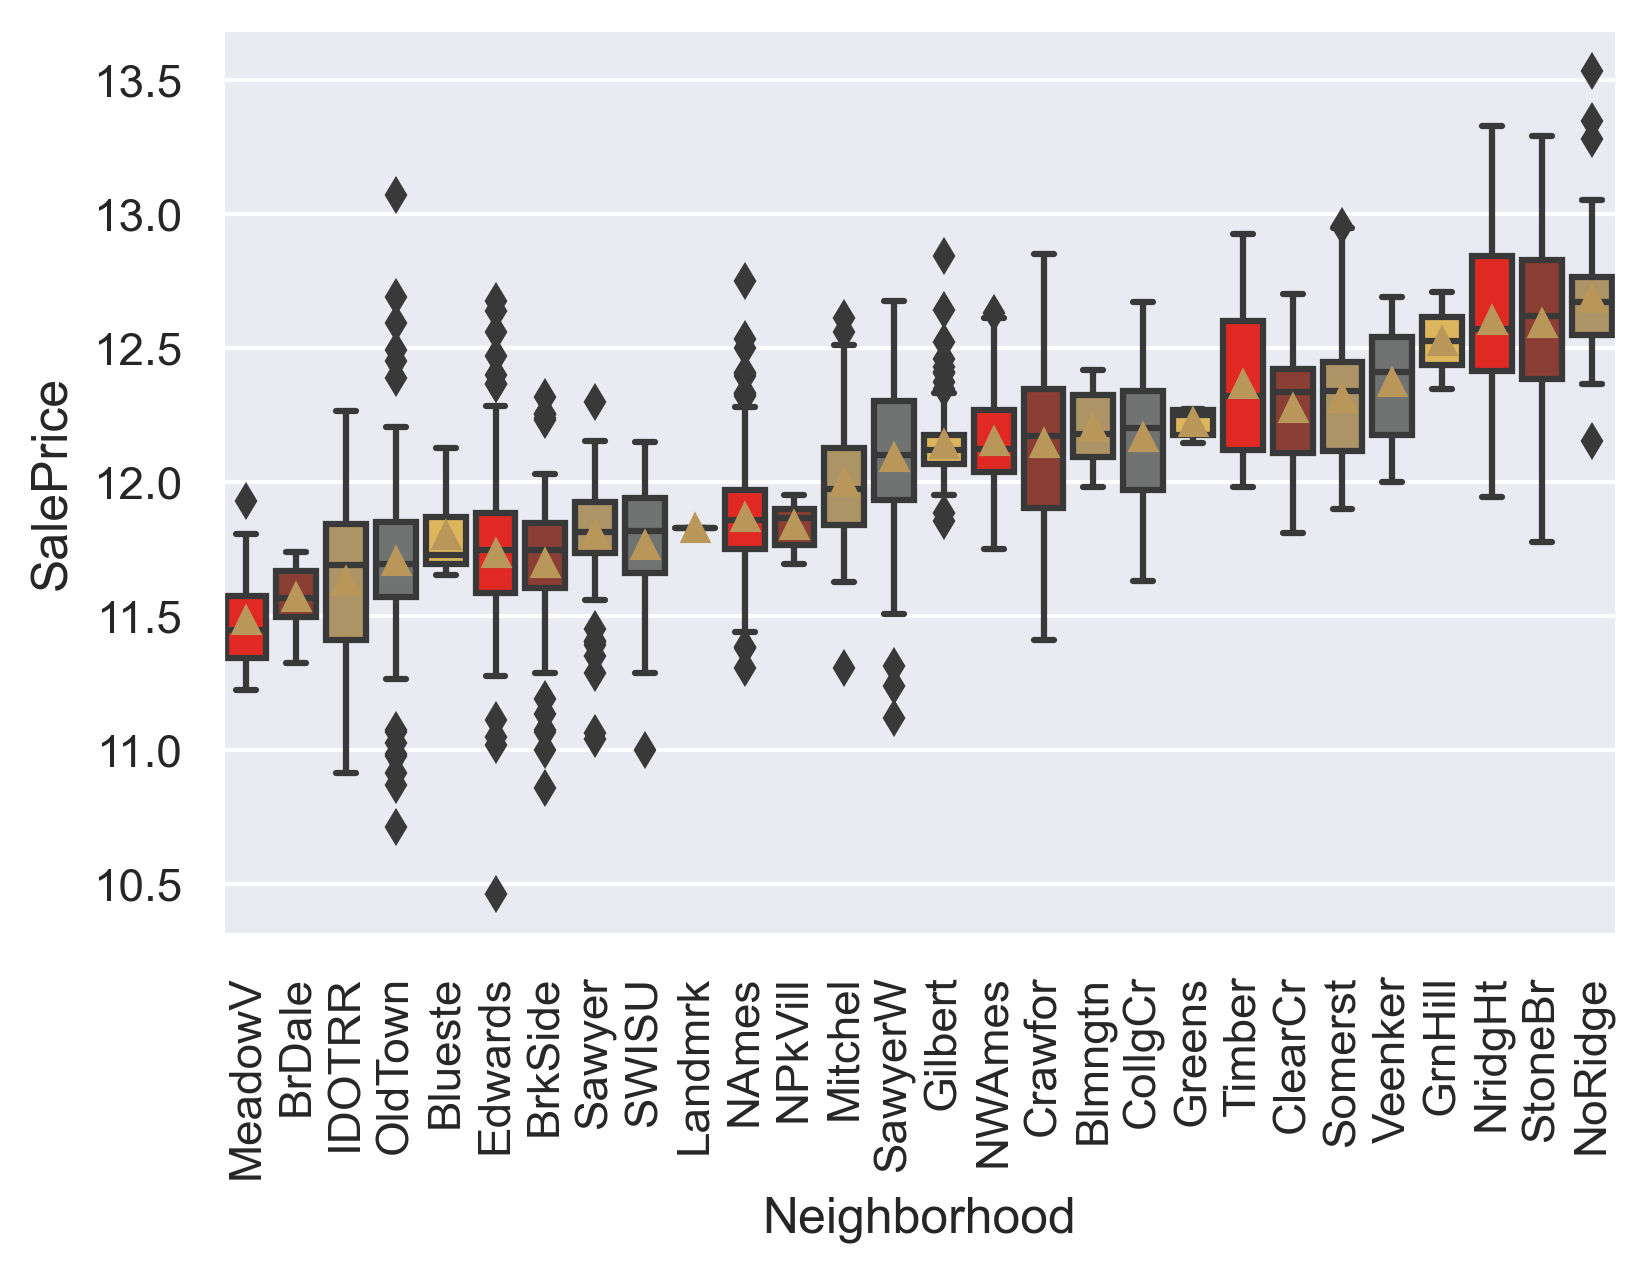

In [54]:
x = hous_trn['Neighborhood']
y = np.log(hous_trn['SalePrice'])
_ = sns.boxplot(x=x, y=y, order=nhd_ord, showmeans=True)
_.tick_params(axis='x', rotation=90)
plt.show()

In [59]:
# Min/max per Neighborhood z-scores, based on log of SalePrice

hous_trn['LogSalePrice'] = np.log(hous_trn['SalePrice'])
hous_trn['nhd_z'] = hous_trn.groupby('Neighborhood')['LogSalePrice'].transform(lambda x: zscore(x, ddof=1)).fillna(0)
hous_trn.groupby('Neighborhood').agg({'nhd_z':['min', 'max']})

C:\Users\alexa\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\alexa\Anaconda3\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


nhd_z          
                   min       max
Neighborhood                    
Blmngtn      -1.614391  1.520714
Blueste      -0.879054  1.884238
BrDale       -2.011903  1.405634
BrkSide      -2.837381  2.099917
ClearCr      -2.021464  1.849547
CollgCr      -2.226418  2.087503
Crawfor      -2.467916  2.372835
Edwards      -3.909193  2.887574
Gilbert      -1.977840  4.807187
Greens       -1.343115  0.842102
GrnHill      -0.707107  0.707107
IDOTRR       -2.360195  2.089020
Landmrk       0.000000  0.000000
MeadowV      -1.319148  2.229888
Mitchel      -2.941662  2.610765
NAmes        -2.863471  4.475250
NPkVill      -1.925042  1.447494
NWAmes       -2.153950  2.577928
NoRidge      -2.175713  3.455496
NridgHt      -2.085036  2.297455
OldTown      -3.077391  4.226956
SWISU        -3.132349  1.578567
Sawyer       -3.826794  2.457806
SawyerW      -3.314402  1.986854
Somerst      -1.813208  2.818901
StoneBr      -2.290843  1.953211
Timber       -1.410570  2.058689
Veenker      -1.746804  1.456569

# Investigation of 'Lot'

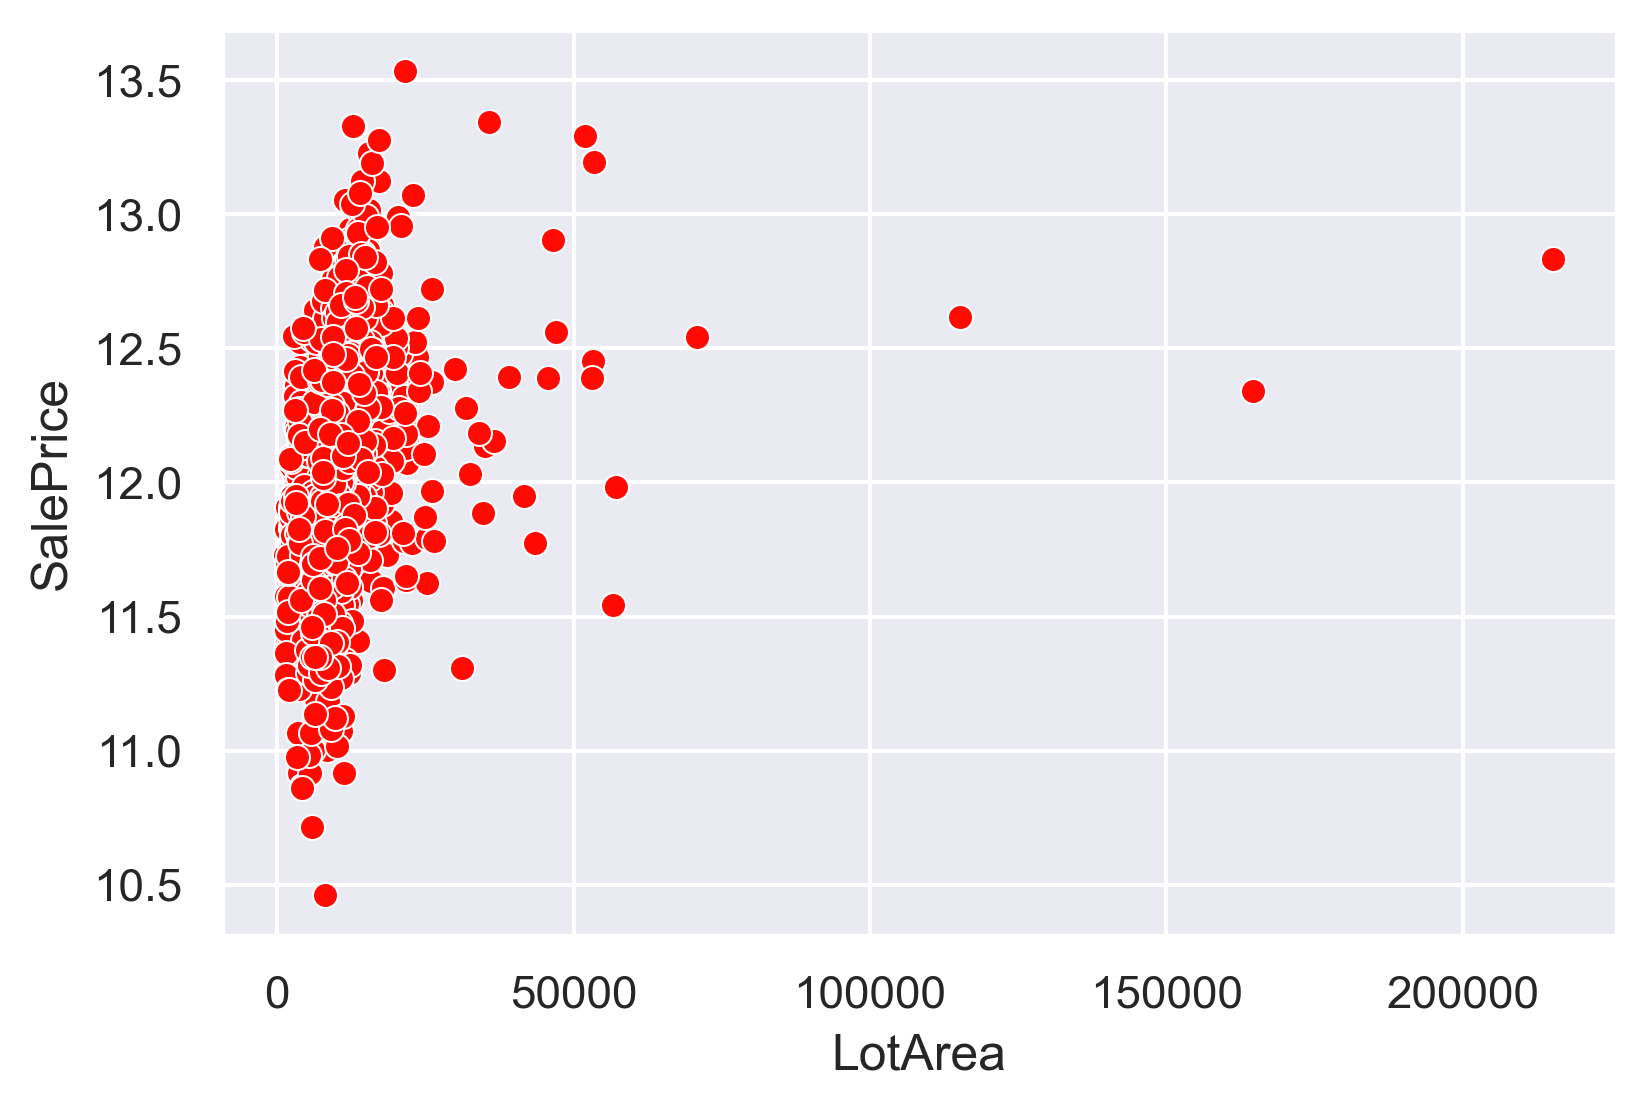

In [112]:
# LotArea is a problematic variable because of some extreme outliers (in terms of lot size).

x = hous_trn['LotArea']
y = np.log(hous_trn['SalePrice'])
sns.scatterplot(x=x, y=y)
plt.show()

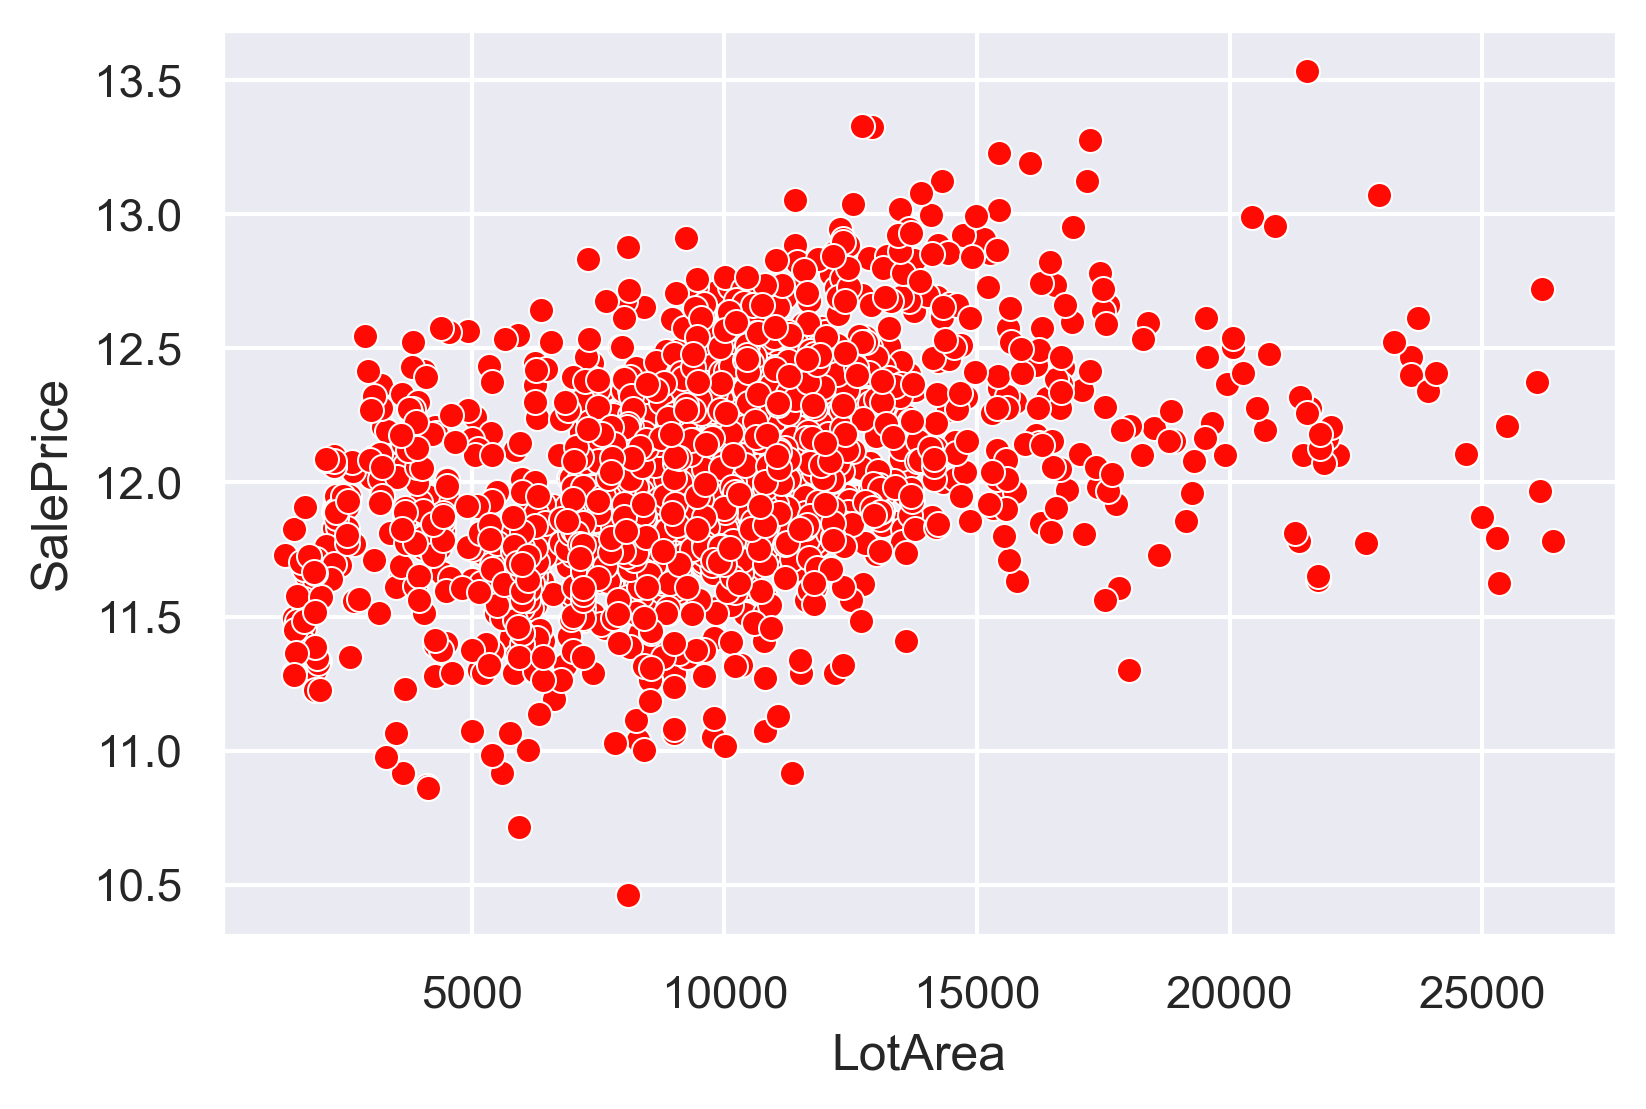

In [113]:
# Removing all houses with lots greater than 28,000 sqft allows to identify some trend.

x = hous_trn['LotArea']
y = np.log(hous_trn.loc[hous_trn['LotArea']<=28000,'SalePrice'])
sns.scatterplot(x=x, y=y)
plt.show()

In [115]:
# How many houses have lots greater than 28,000 sqft? Notice it is not
# complexes of some sort, it is single family homes with large yards.

hous_trn.loc[hous_trn['LotArea']>28000, 'BldgType'].value_counts()

1Fam      21
2fmCon     4
Name: BldgType, dtype: int64

In [117]:
# What difference do the outliers make to a simpe linear regression?

X = hous_trn[['LotArea']]
y = np.log(hous_trn['SalePrice'])
reg.fit(X,y)
reg.score(X,y)

0.07456045729672411

In [121]:
X = np.array(hous_trn.loc[hous_trn['LotArea']<=28000,'LotArea']).reshape(-1,1)
y = np.log(hous_trn.loc[hous_trn['LotArea']<=28000,'SalePrice'])
reg.fit(X,y)
reg.score(X,y)

0.16540588678498347

## ^^More than double the R^2!

In [122]:
# Does LotArea also prefer a log transform similar to GrLivArea? (No.)

X = np.log(np.array(hous_trn.loc[hous_trn['LotArea']<=28000,'LotArea'])).reshape(-1,1)
y = np.log(hous_trn.loc[hous_trn['LotArea']<=28000,'SalePrice'])
reg.fit(X,y)
reg.score(X,y)

0.15500582391240225

#### In order to decide how to impute, we take a look at LotArea.

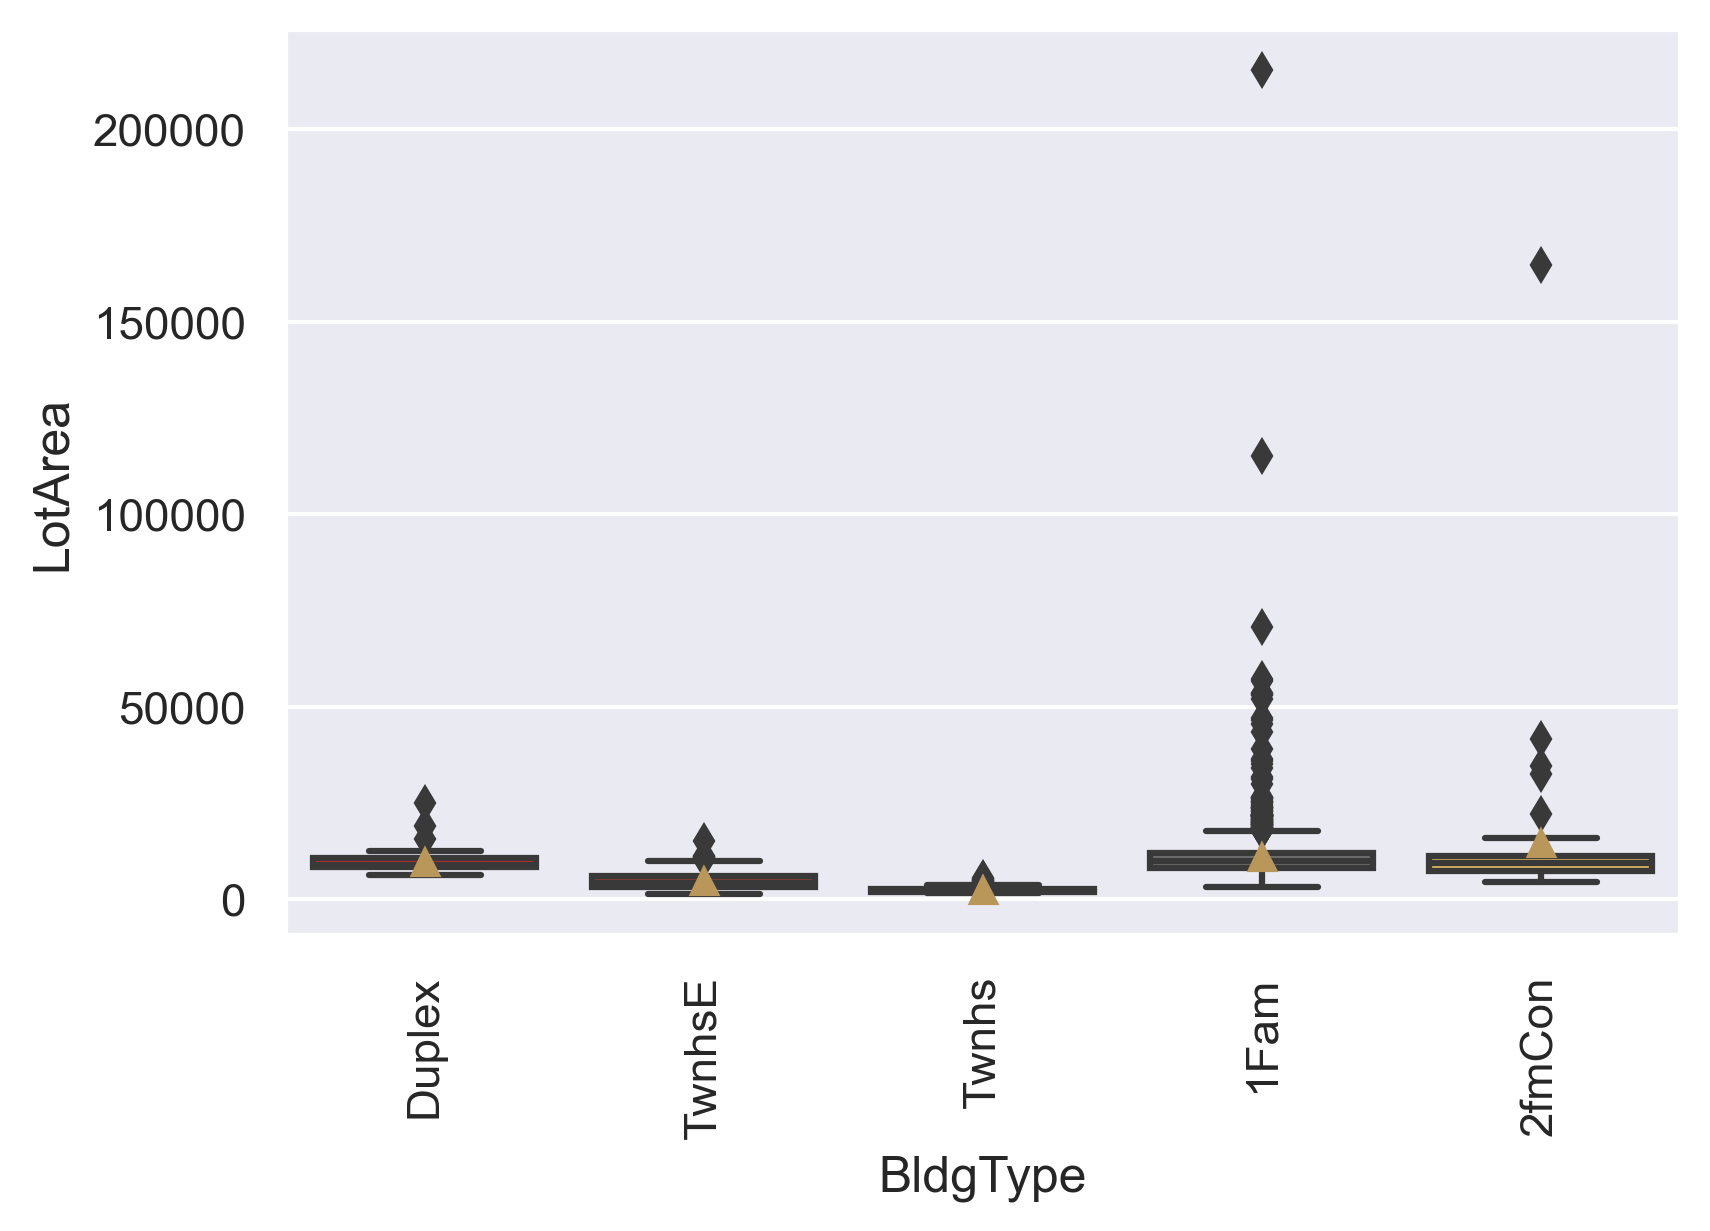

In [77]:
# Outliers make the following useless.
x = hous_trn['BldgType']
y = hous_trn['LotArea']
_ = sns.boxplot(x=x, y=y, showmeans=True)
_.tick_params(axis='x', rotation=90)
plt.show()

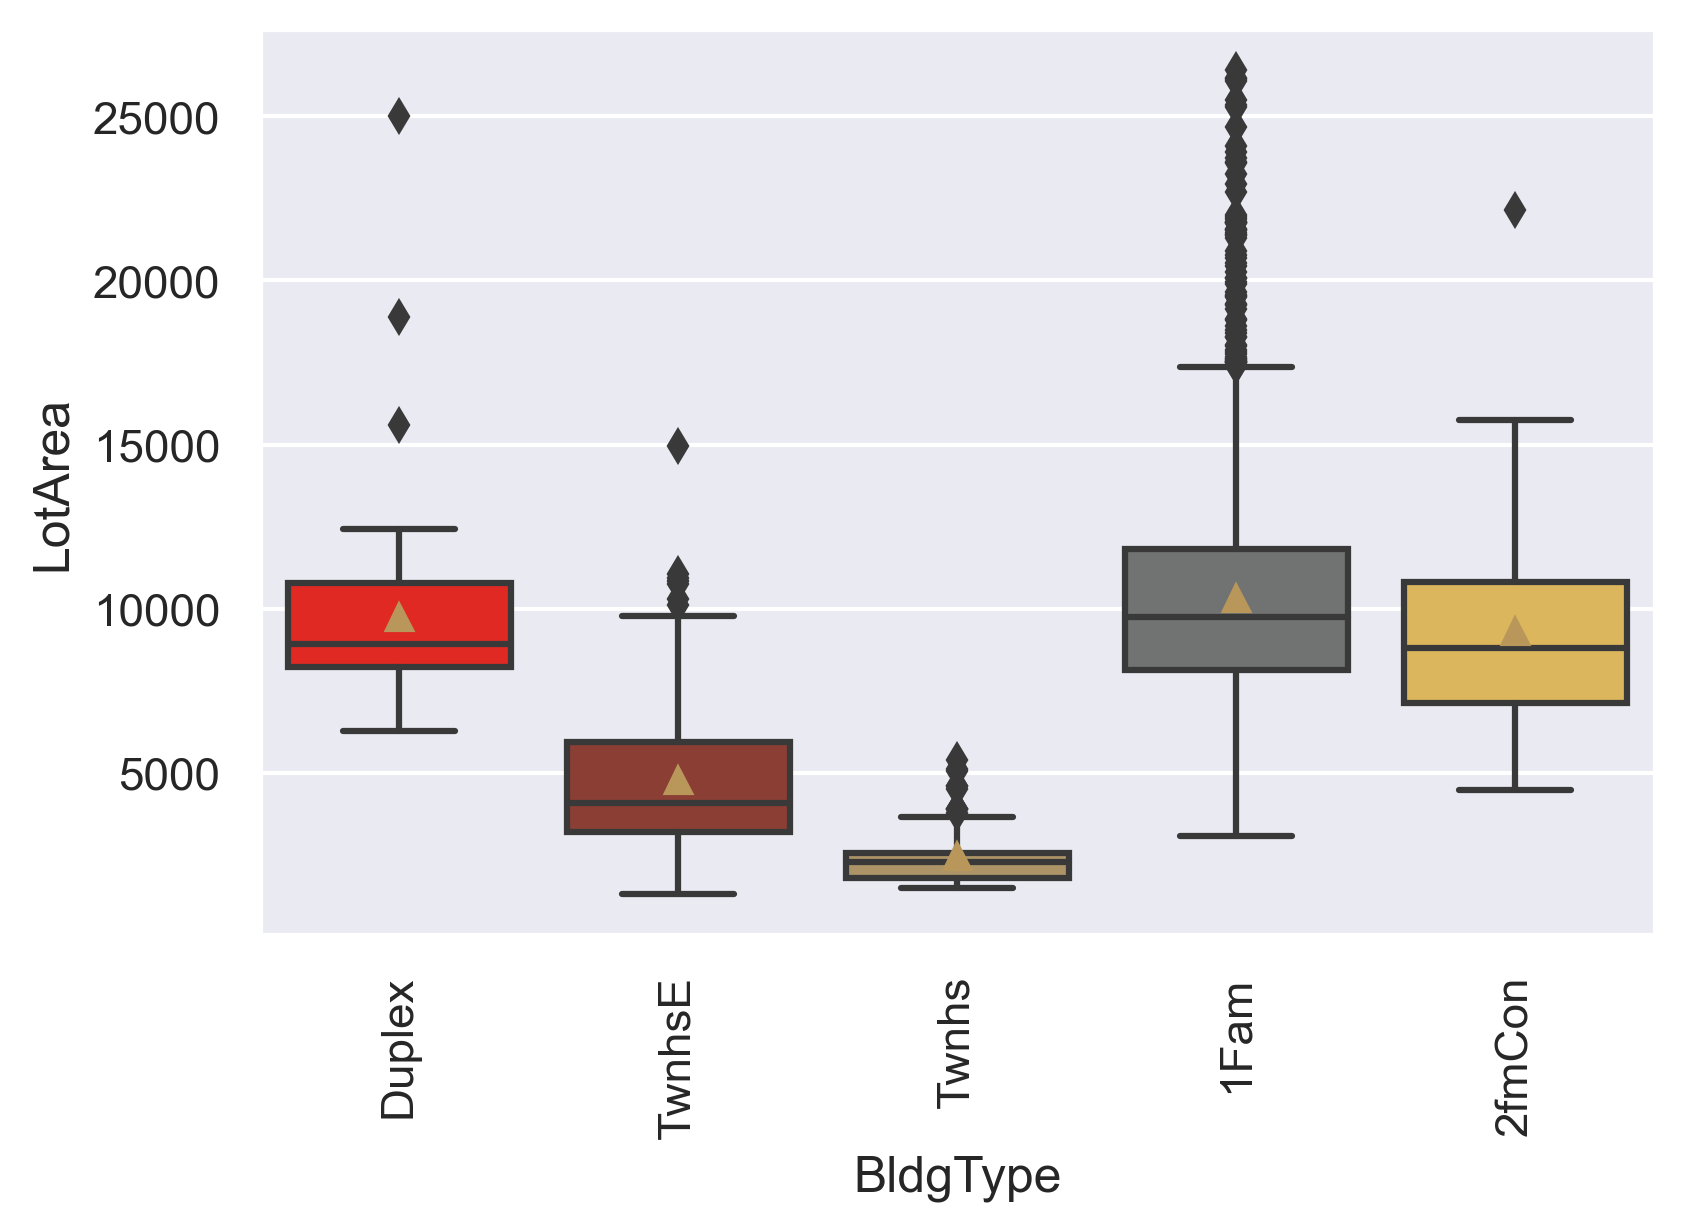

In [79]:
# Rerun excluding any lots over 28,000 sqft.
# Outliers make the following useless.
x = hous_trn[hous_trn['LotArea']<=28000]['BldgType']
y = hous_trn[hous_trn['LotArea']<=28000]['LotArea']
_ = sns.boxplot(x=x, y=y, showmeans=True)
_.tick_params(axis='x', rotation=90)
plt.show()

In [82]:
# Is there a relationship between the missingness and building type?
hous_trn[hous_trn['LotFrontage'].isna()]['BldgType'].value_counts()

1Fam      300
TwnhsE     29
Duplex     15
Twnhs       6
2fmCon      3
Name: BldgType, dtype: int64

In [91]:
missing = hous_trn[hous_trn['LotFrontage'].isna()]['BldgType'].value_counts()
total = hous_trn['BldgType'].value_counts()
idx = total.index
tmp_tbl_1 = pd.DataFrame({'total':total, 'missing':missing}, index=idx)
tmp_tbl_1['proportion_missing'] = round(tmp_tbl_1['missing']/tmp_tbl_1['total'],2)
tmp_tbl_1

total  missing  proportion_missing
1Fam     1549      300                0.19
TwnhsE    151       29                0.19
Twnhs      69        6                0.09
Duplex     56       15                0.27
2fmCon     46        3                0.07

In [109]:
hous_trn['SqrtLotArea'] = np.sqrt(hous_trn['LotArea'])

In [110]:
# If nothing else, common sense plus the high proportion of 'Duplex' suggests
# a formula for imputing based on 'BldgType'. We assume a relationship of the form
# LotFrontage = alpha * sqrt(LotArea), and discover the alpha for each building 
# type using a simple linear regression.
LotFrontage_impute_coefs = []
LF_notnull = hous_trn[~hous_trn['LotFrontage'].isna()]
idx = hous_trn['BldgType'].value_counts().index
for bldgtype in idx:
    X = LF_notnull[LF_notnull['BldgType']==bldgtype][['SqrtLotArea']]
    y = LF_notnull[LF_notnull['BldgType']==bldgtype]['LotFrontage']
    reg_0 = linear_model.LinearRegression(fit_intercept=False).fit(X,y)
    LotFrontage_impute_coefs.append(round(reg_0.coef_[0], 4))
LotFrontage_impute_coefs = pd.DataFrame({'coef':LotFrontage_impute_coefs}, index=idx)
LotFrontage_impute_coefs

coef
1Fam    0.7139
TwnhsE  0.5849
Twnhs   0.5227
Duplex  0.7725
2fmCon  0.6922

### We now turn out attention to the categorical lot variables.

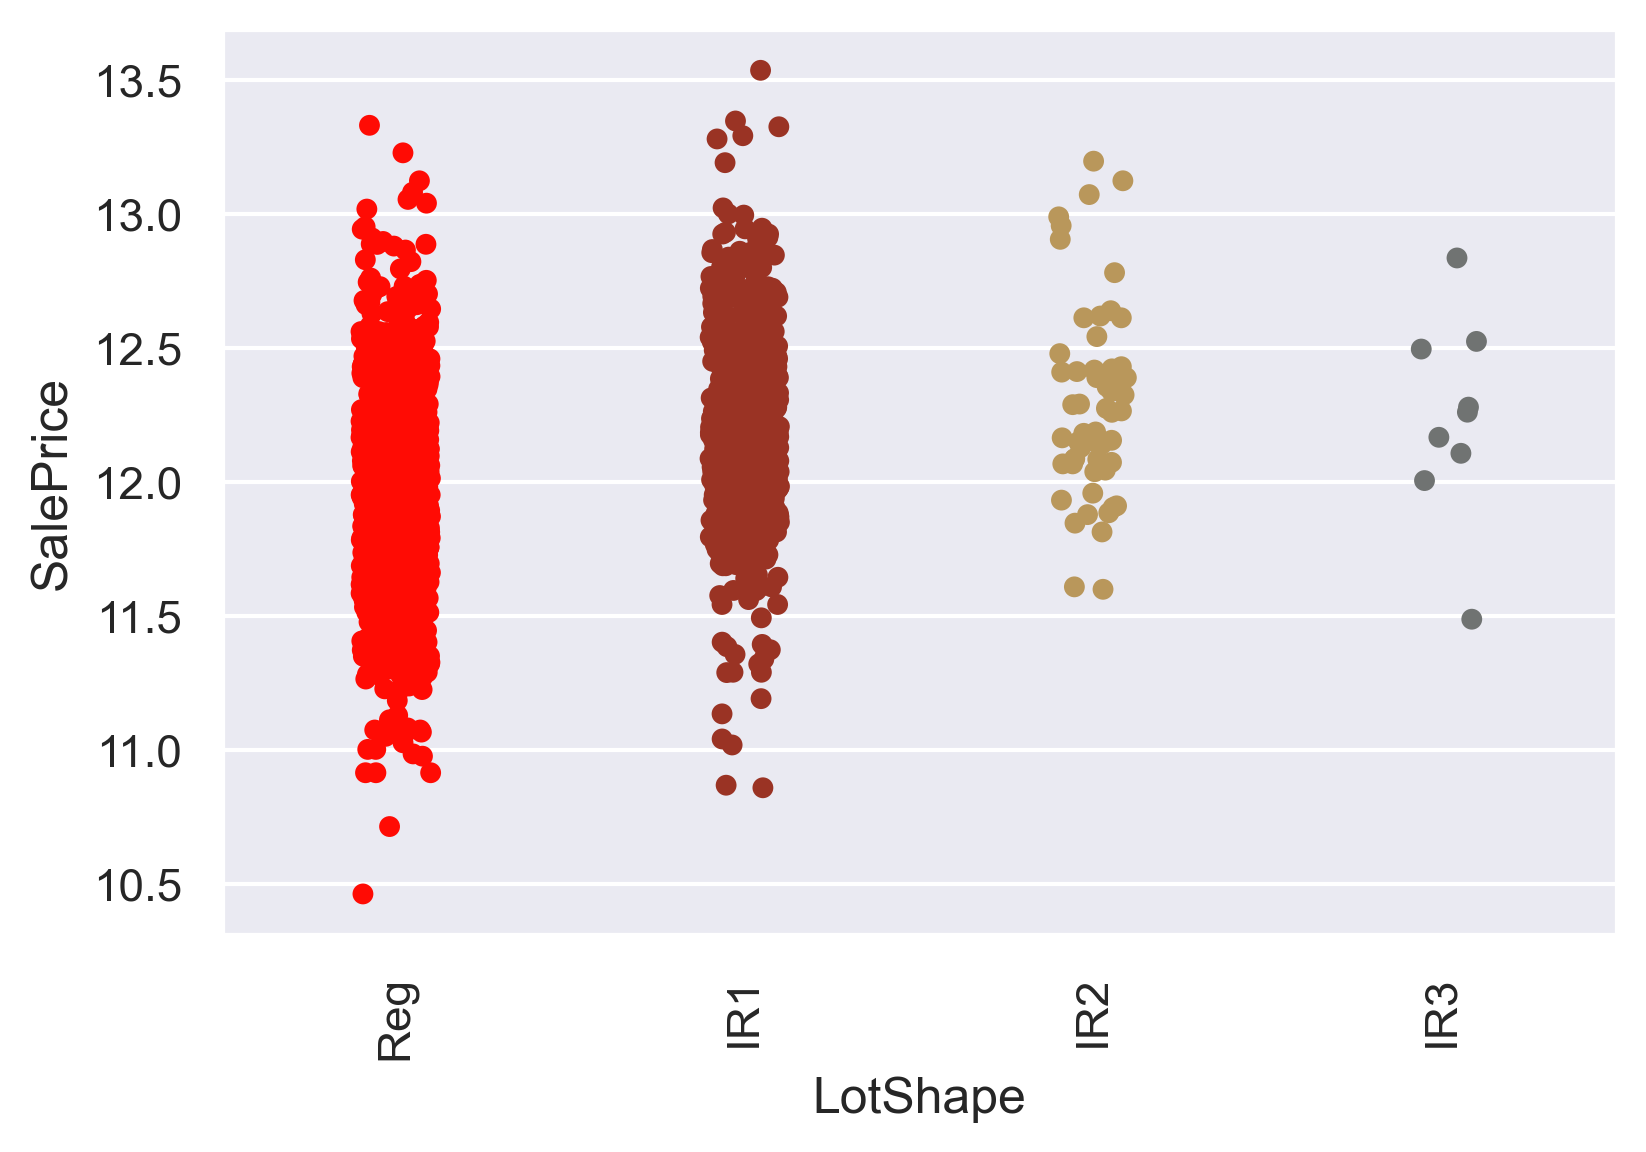

In [126]:
x = hous_trn['LotShape']
y = np.log(hous_trn['SalePrice'])
_ = sns.stripplot(x=x, y=y)
_.tick_params(axis='x', rotation=90)
plt.show()

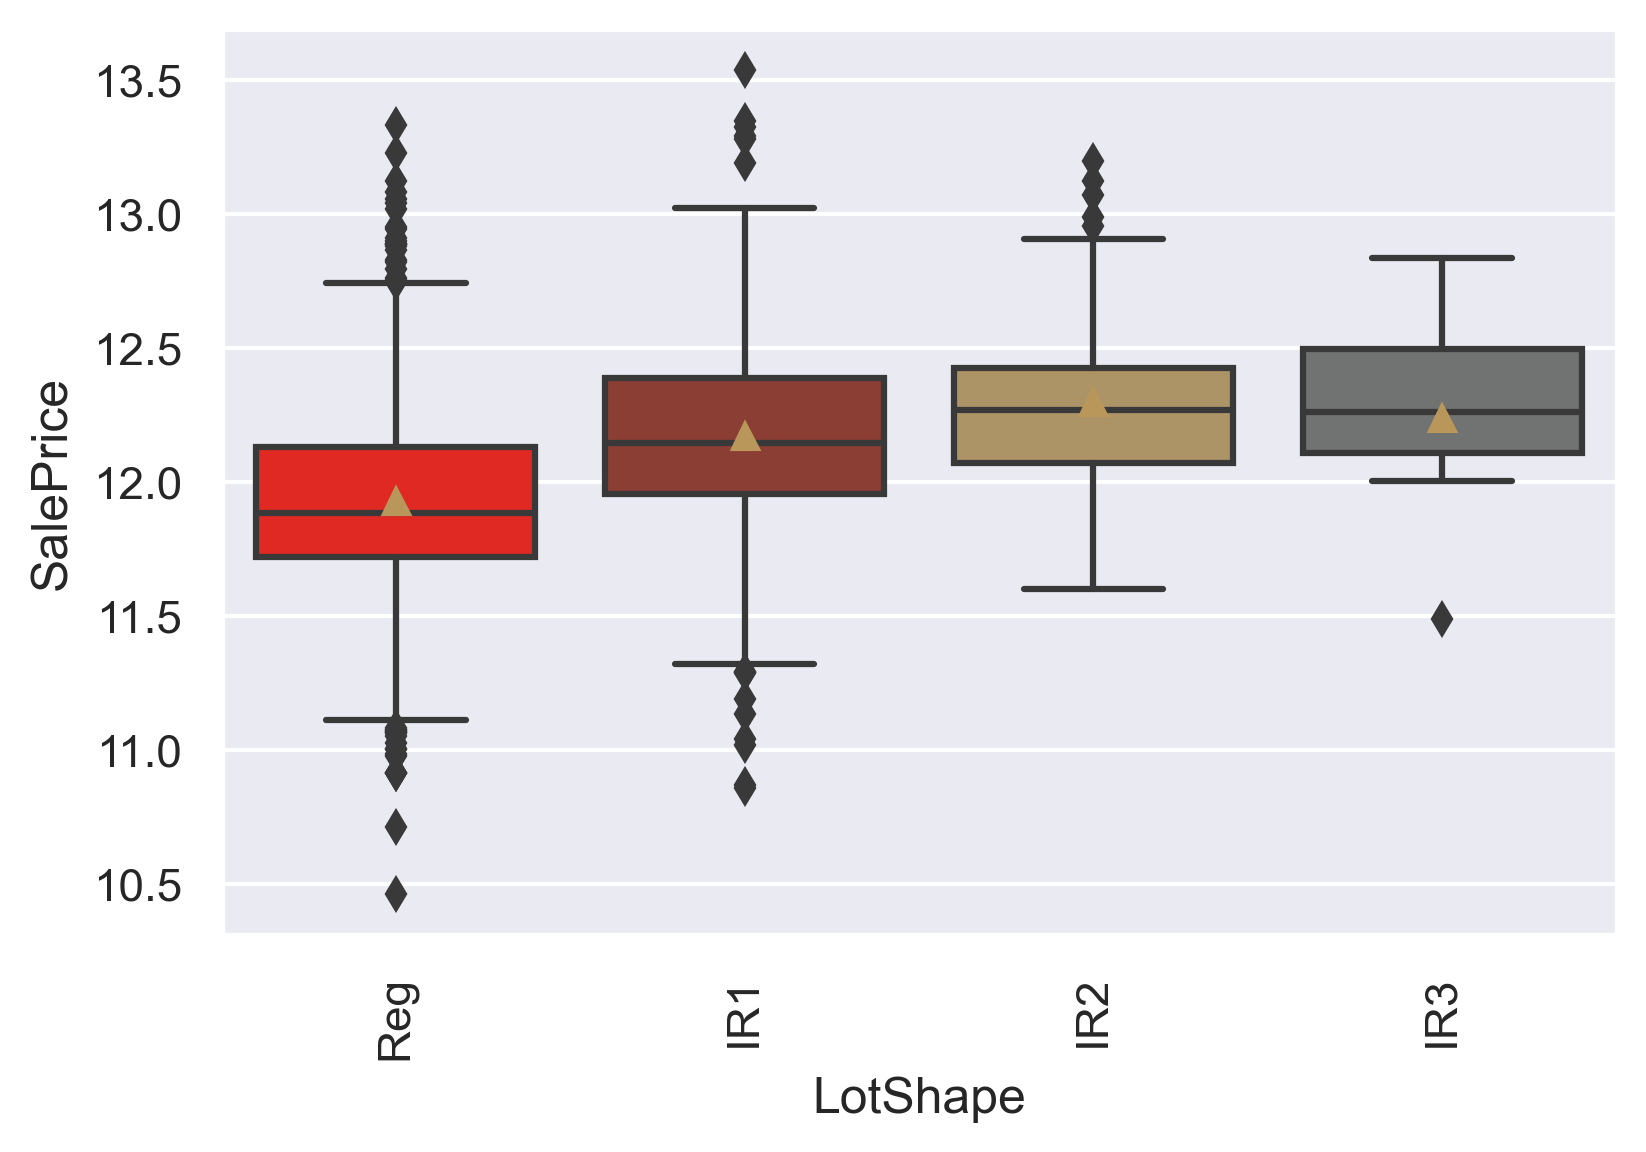

In [125]:
x = hous_trn['LotShape']
y = np.log(hous_trn['SalePrice'])
_ = sns.boxplot(x=x, y=y, showmeans=True)
_.tick_params(axis='x', rotation=90)
plt.show()

## The above suggests that if LotShape were to be used (but don't?) it should be onehot-encoded.

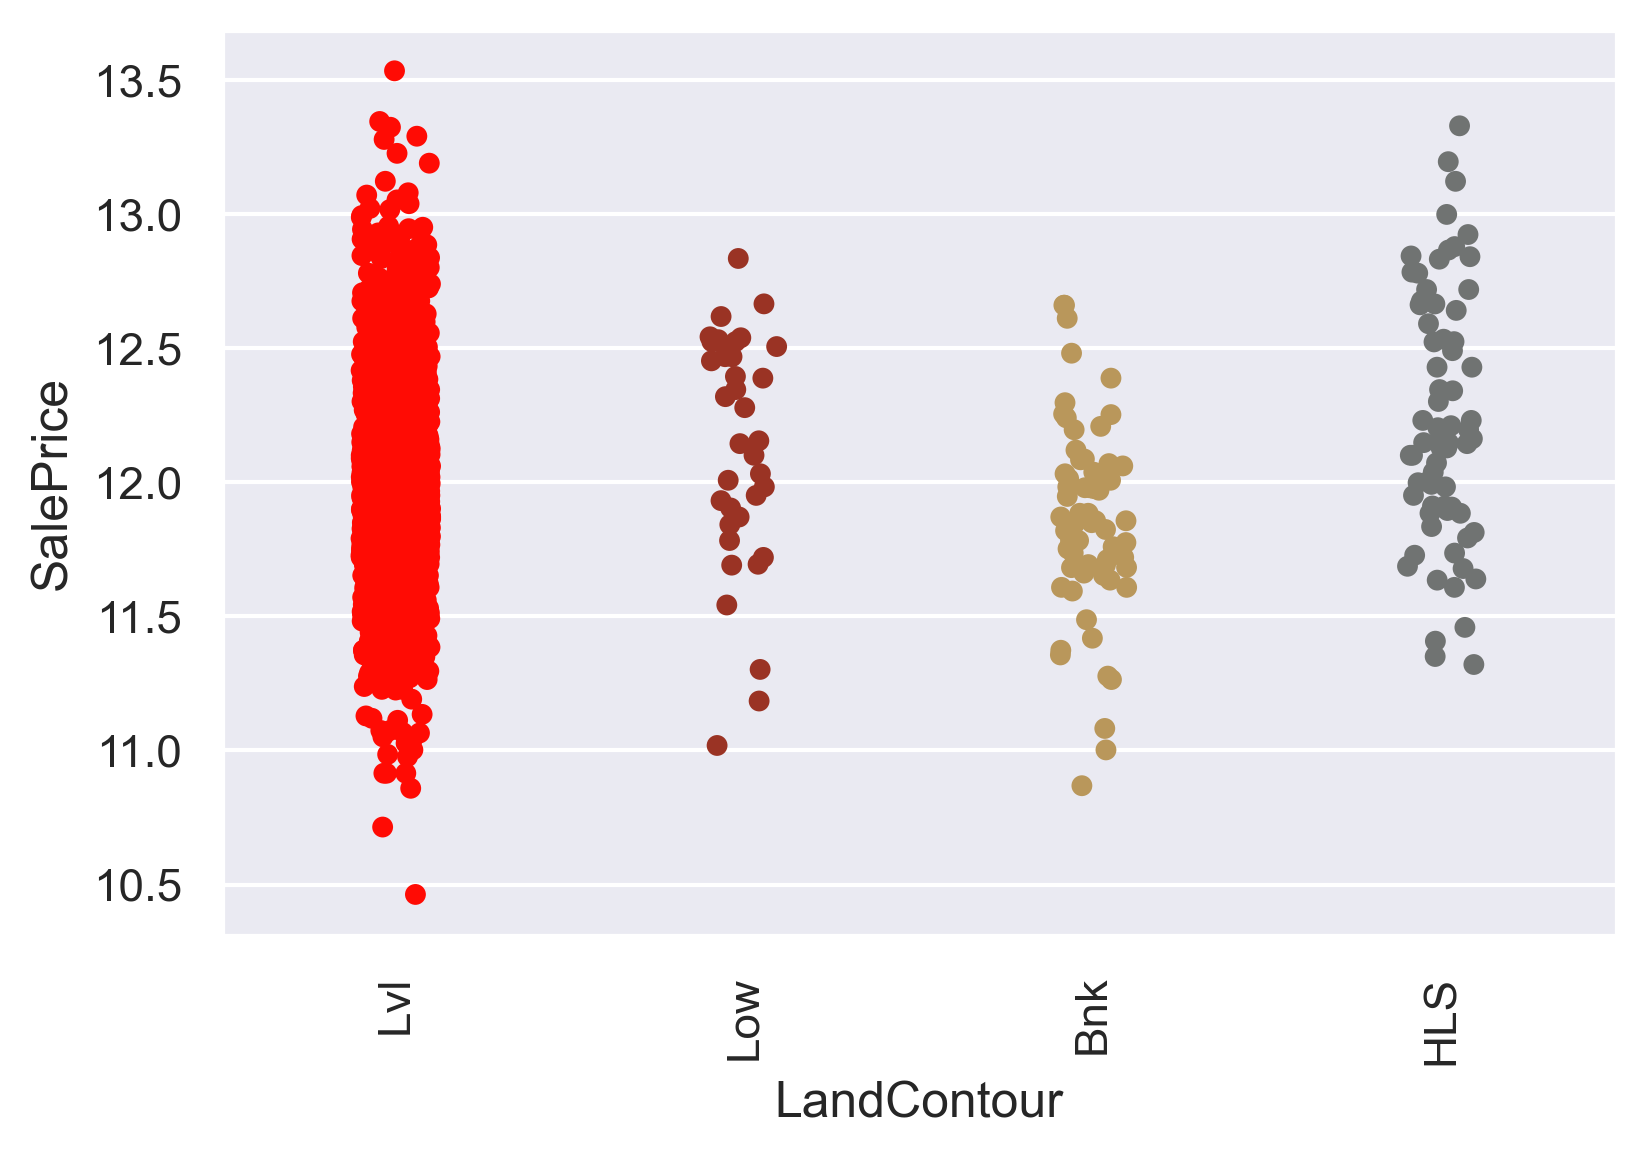

In [129]:
x = hous_trn['LandContour']
y = np.log(hous_trn['SalePrice'])
_ = sns.stripplot(x=x, y=y)
_.tick_params(axis='x', rotation=90)
plt.show()

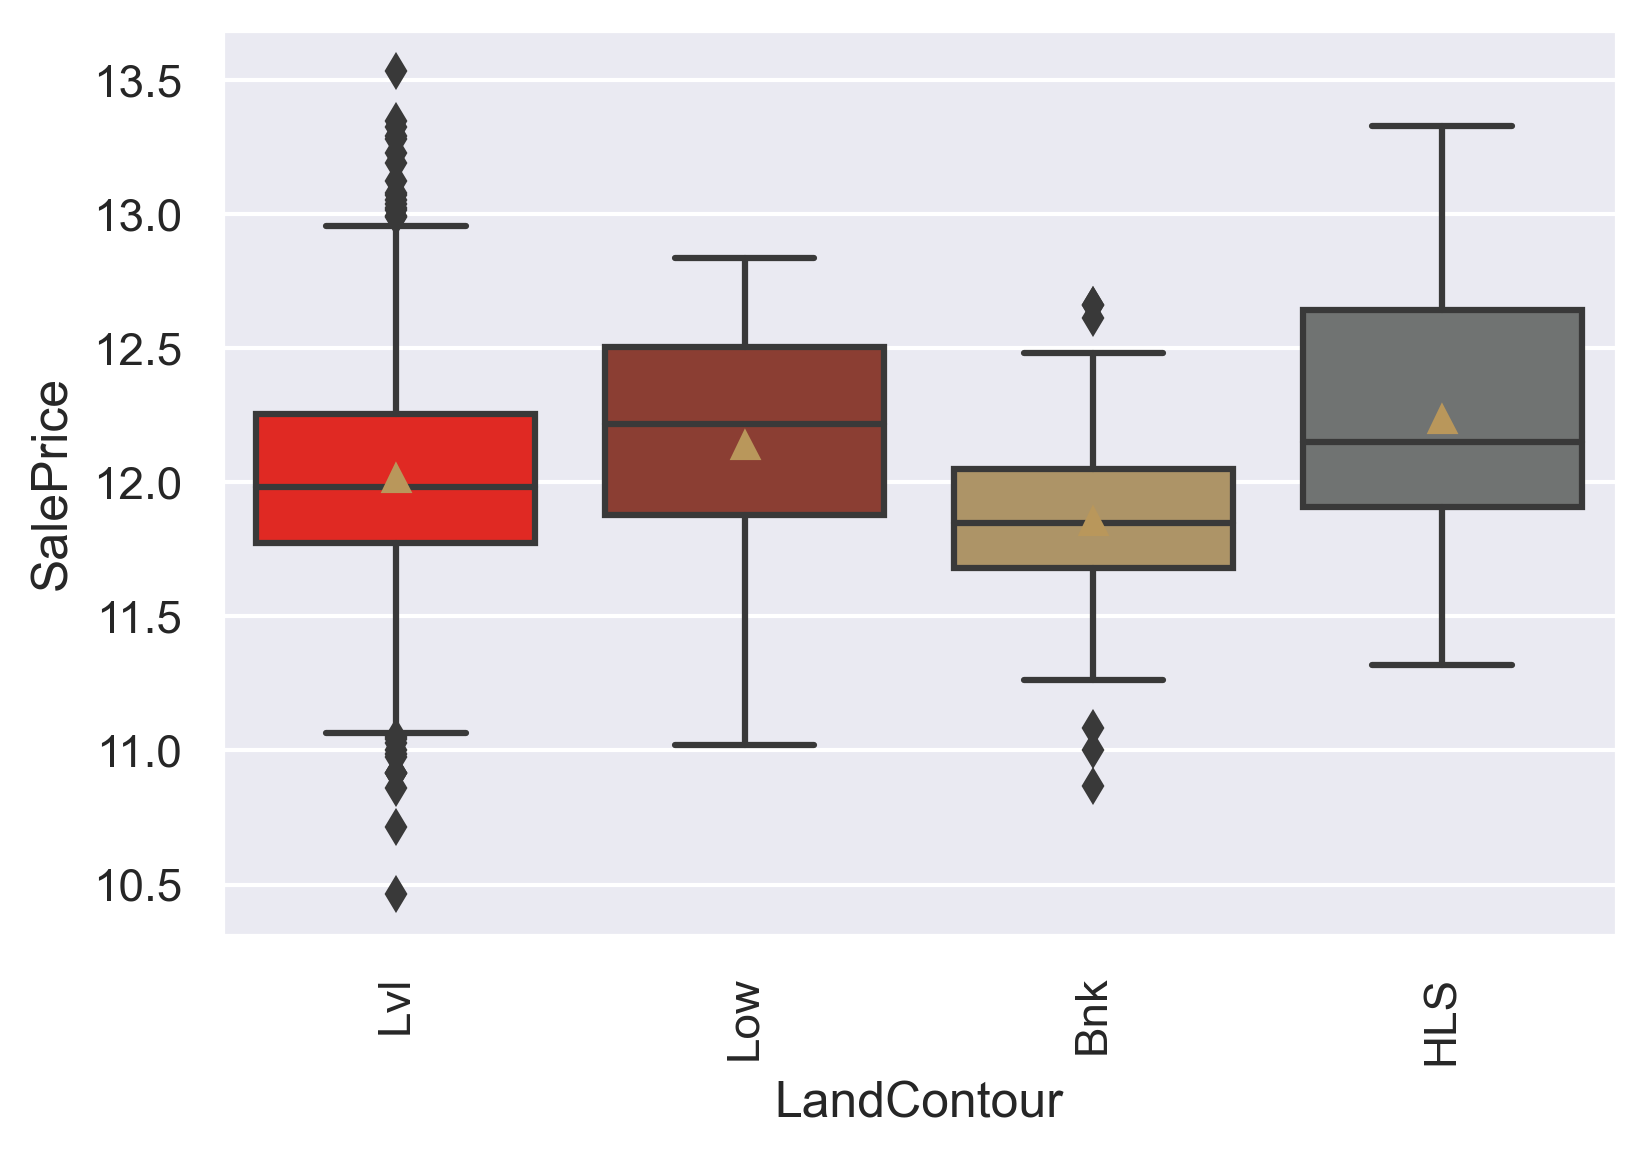

In [130]:
x = hous_trn['LandContour']
y = np.log(hous_trn['SalePrice'])
_ = sns.boxplot(x=x, y=y, showmeans=True)
_.tick_params(axis='x', rotation=90)
plt.show()

### Similar conclusion to LotShape.

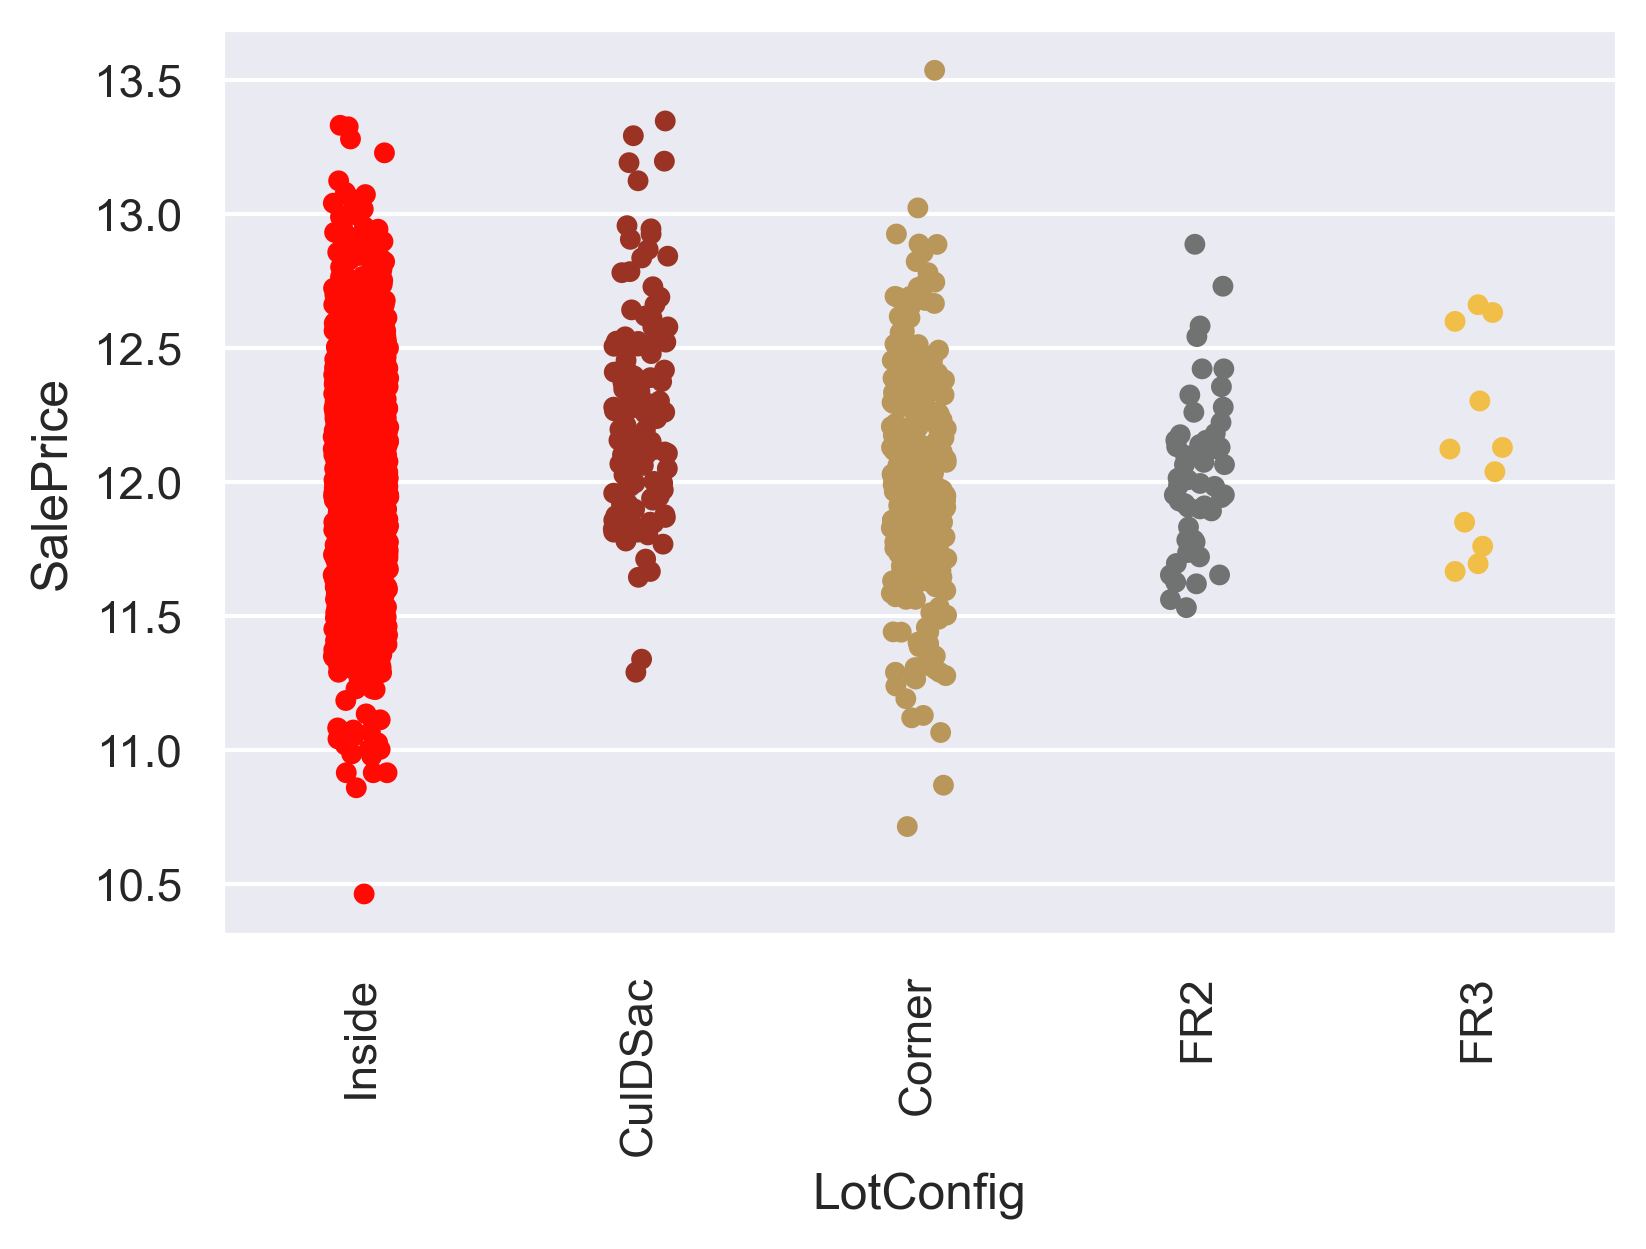

In [133]:
x = hous_trn['LotConfig']
y = np.log(hous_trn['SalePrice'])
_ = sns.stripplot(x=x, y=y)
_.tick_params(axis='x', rotation=90)
plt.show()

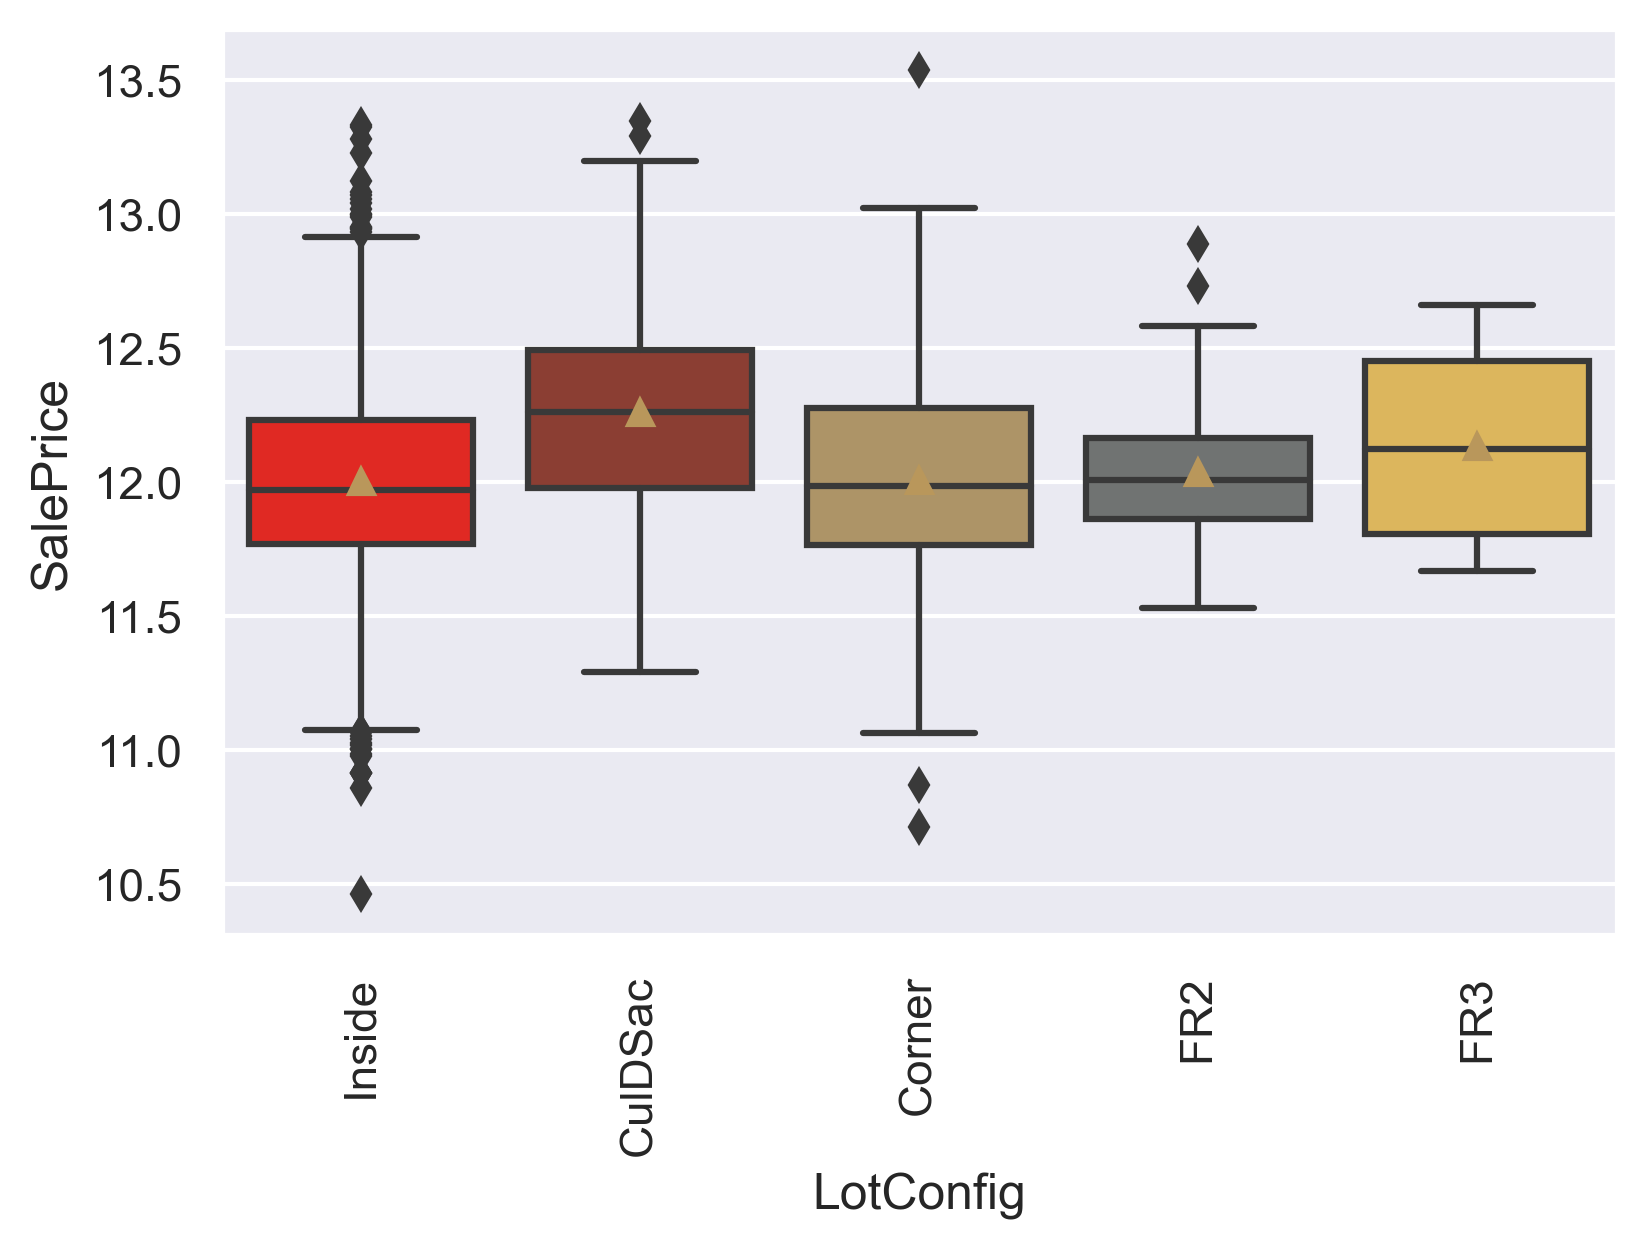

In [134]:
x = hous_trn['LotConfig']
y = np.log(hous_trn['SalePrice'])
_ = sns.boxplot(x=x, y=y, showmeans=True)
_.tick_params(axis='x', rotation=90)
plt.show()

### Here there is more justification for using, but should be onhot-encoded.

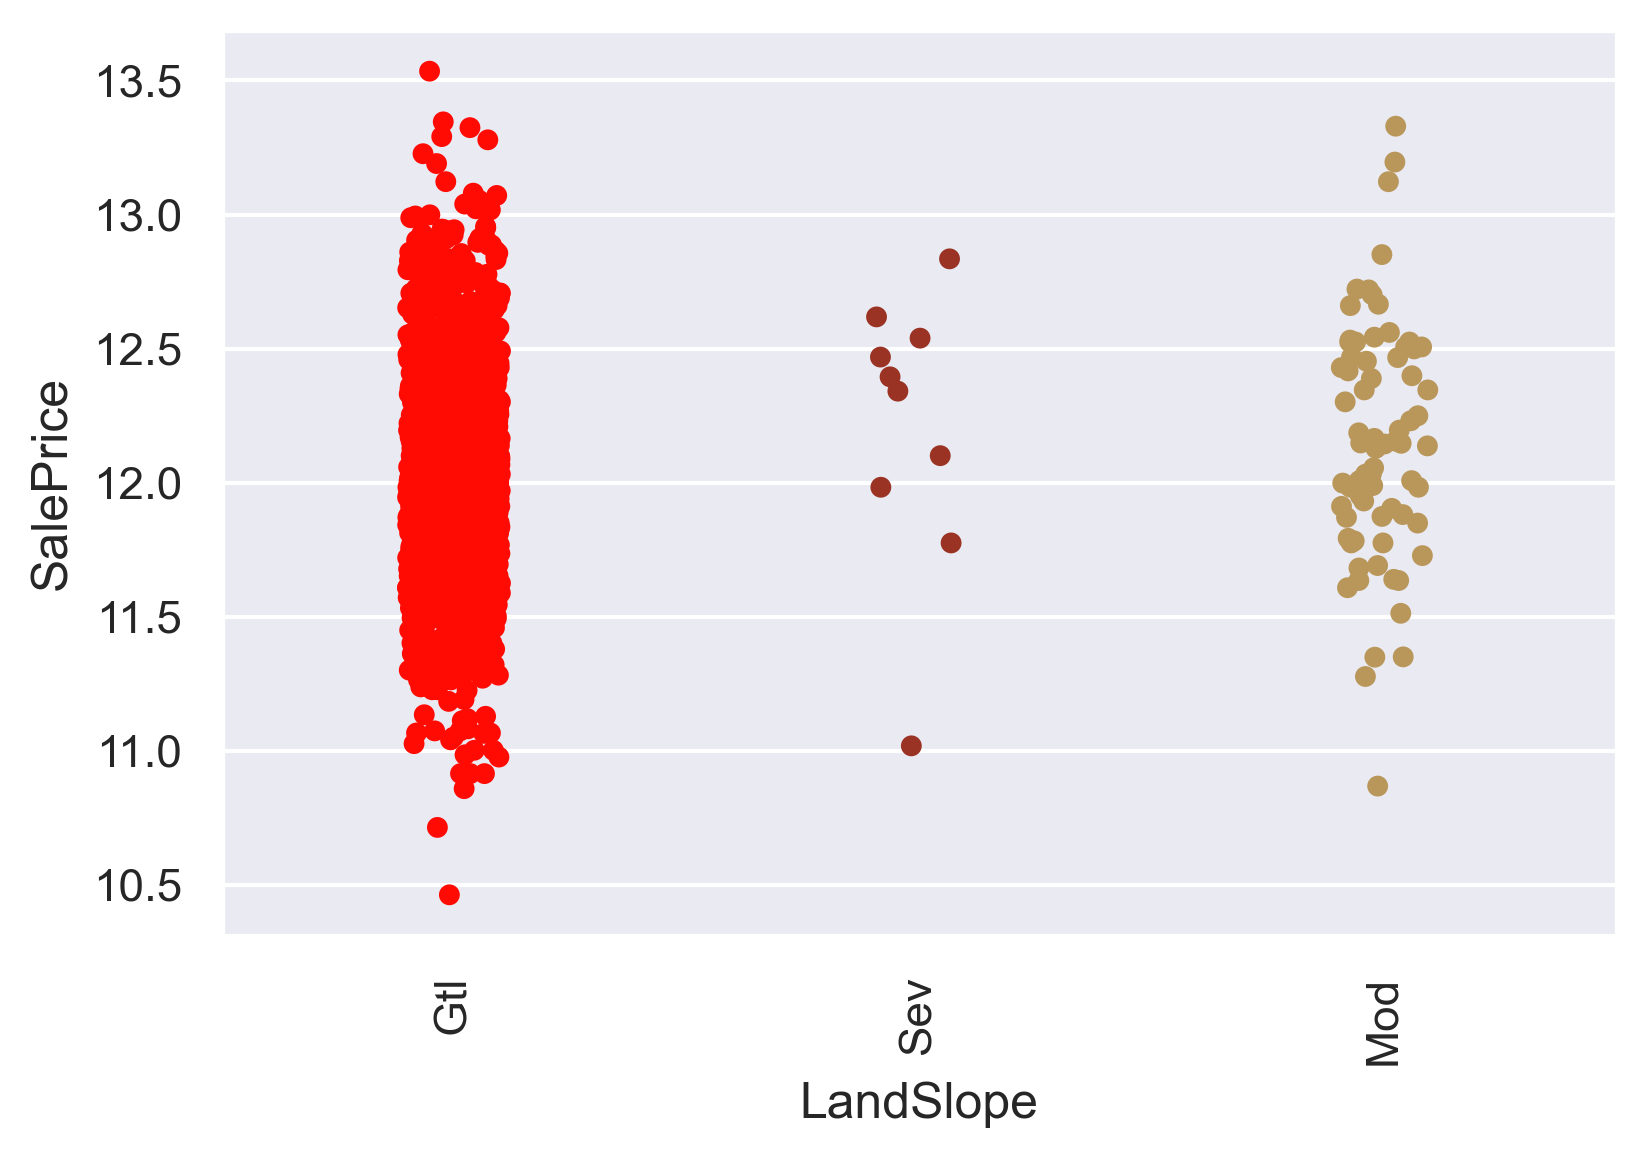

In [135]:
x = hous_trn['LandSlope']
y = np.log(hous_trn['SalePrice'])
_ = sns.stripplot(x=x, y=y)
_.tick_params(axis='x', rotation=90)
plt.show()

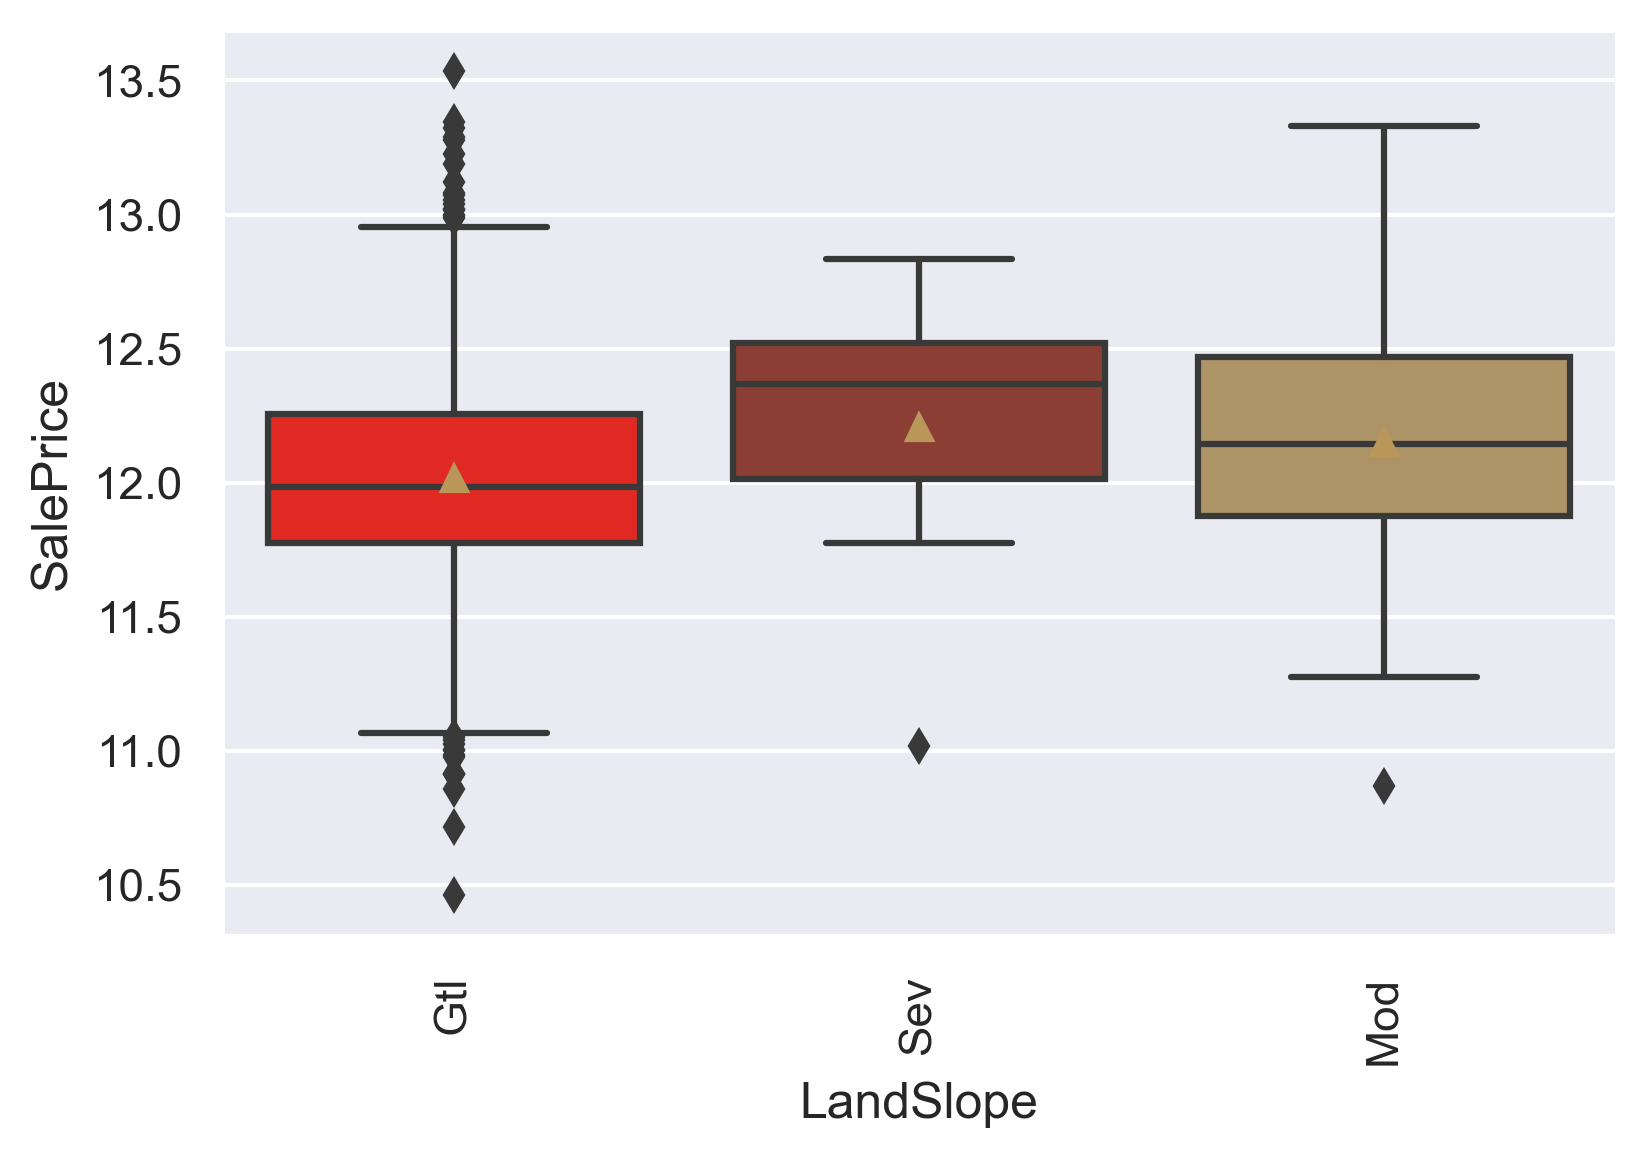

In [136]:
x = hous_trn['LandSlope']
y = np.log(hous_trn['SalePrice'])
_ = sns.boxplot(x=x, y=y, showmeans=True)
_.tick_params(axis='x', rotation=90)
plt.show()

### Suggest not using, but if used should be onehot-encoded.

# Investigation of 'BedroomAbvGr'

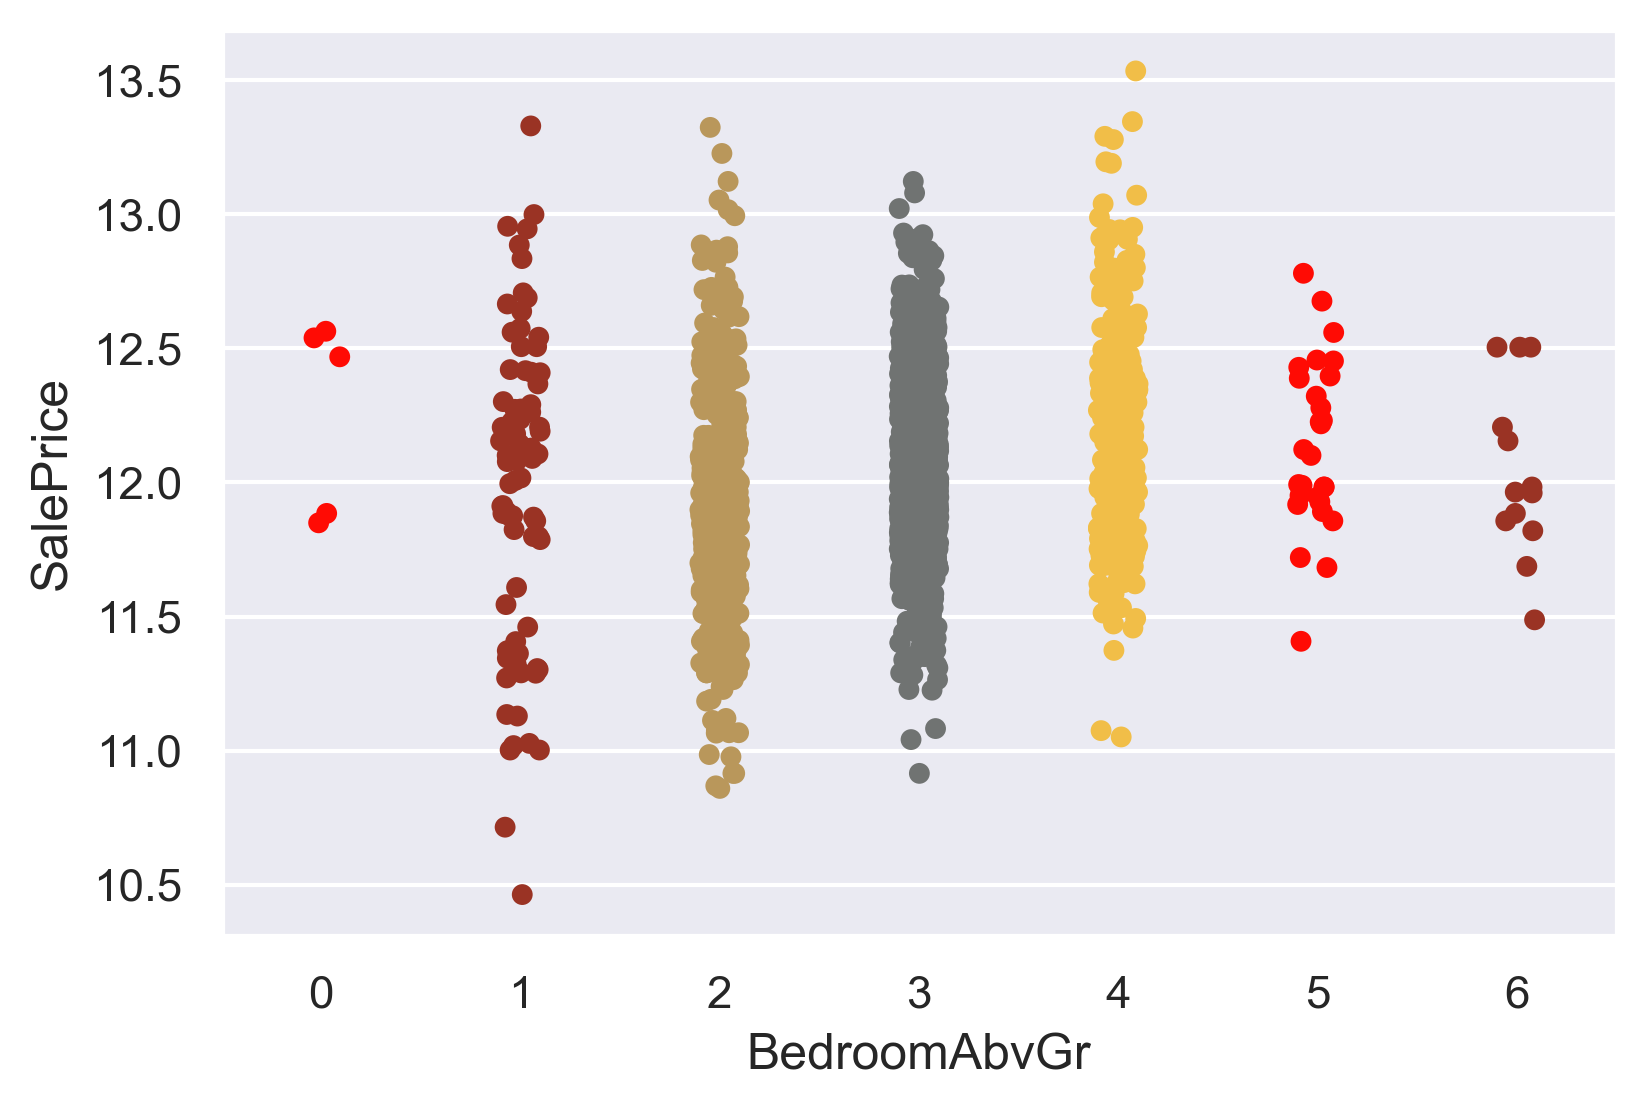

In [137]:
x = hous_trn['BedroomAbvGr']
y = np.log(hous_trn['SalePrice'])
sns.stripplot(x=x, y=y)
plt.show()

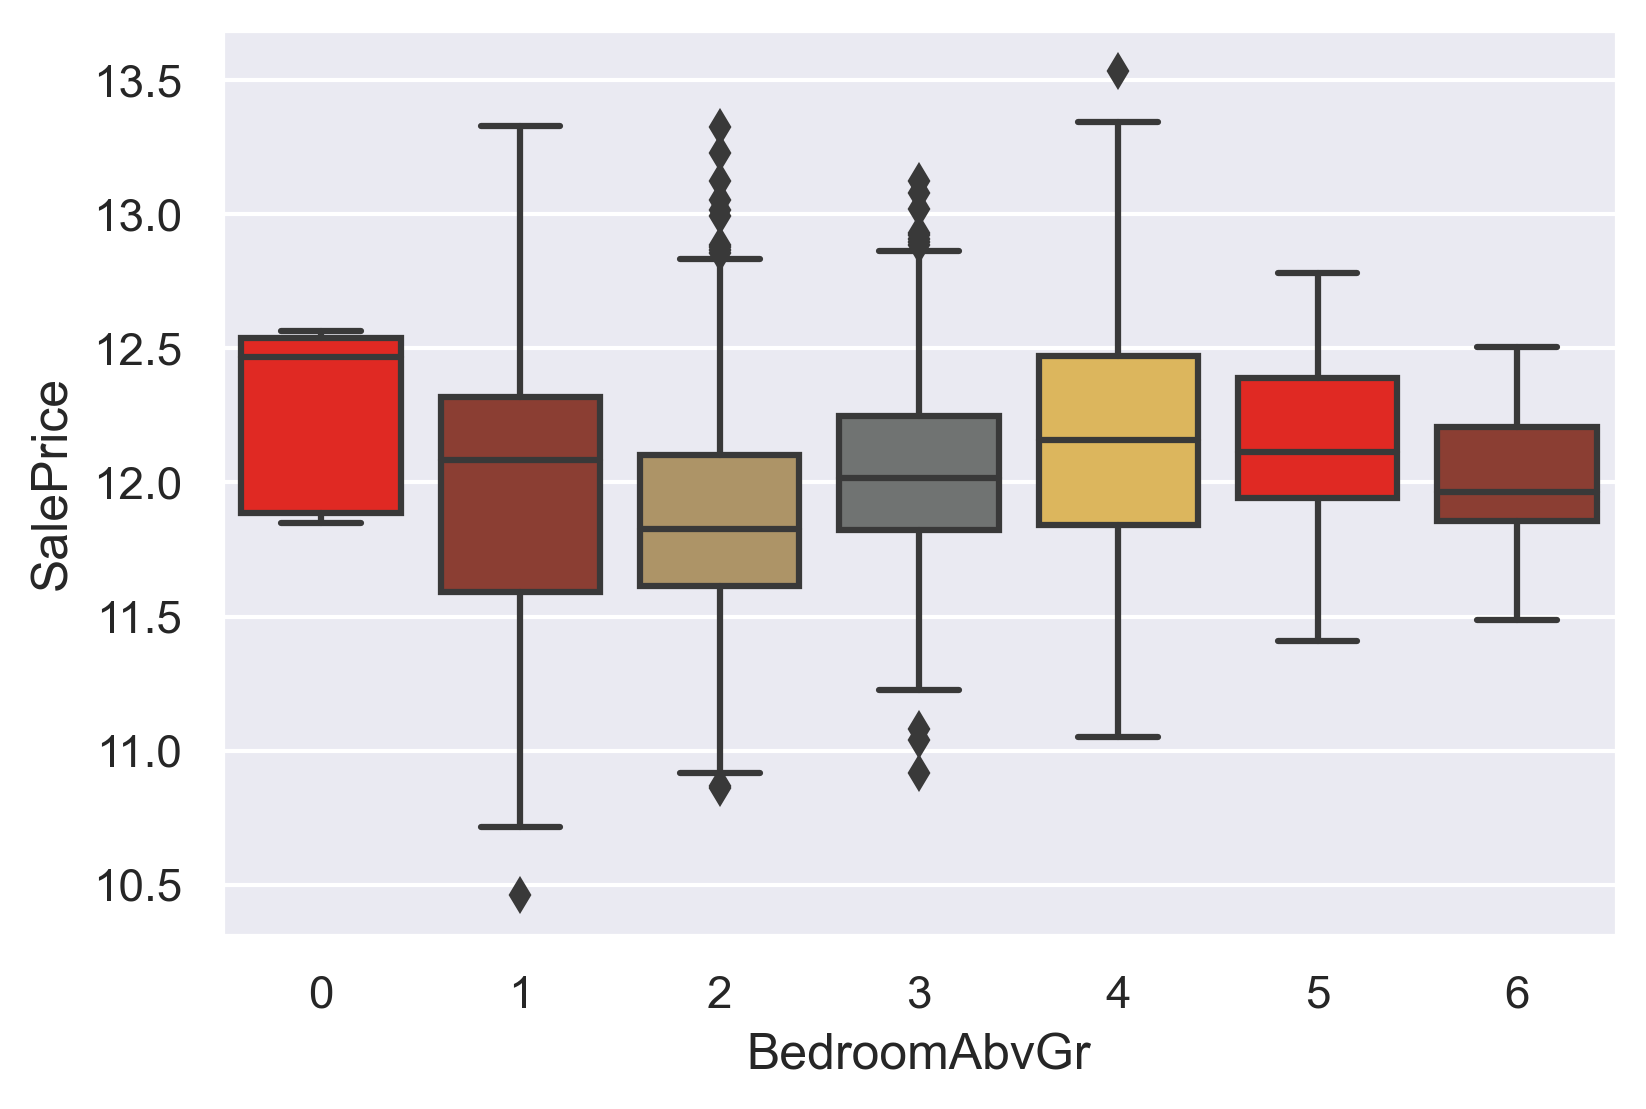

In [138]:
x = hous_trn['BedroomAbvGr']
y = np.log(hous_trn['SalePrice'])
sns.boxplot(x=x, y=y)
plt.show()

### ^^Onehot encode. Should we include 0 bedrooms? What can be done about the 1 beds having such a wide distribution, etc.? Could number of bedrooms be a good segmentation?

# Investigation of 'Porch'

### A nice thing about the porch variables is that they are all in sqft and there are no missing values.

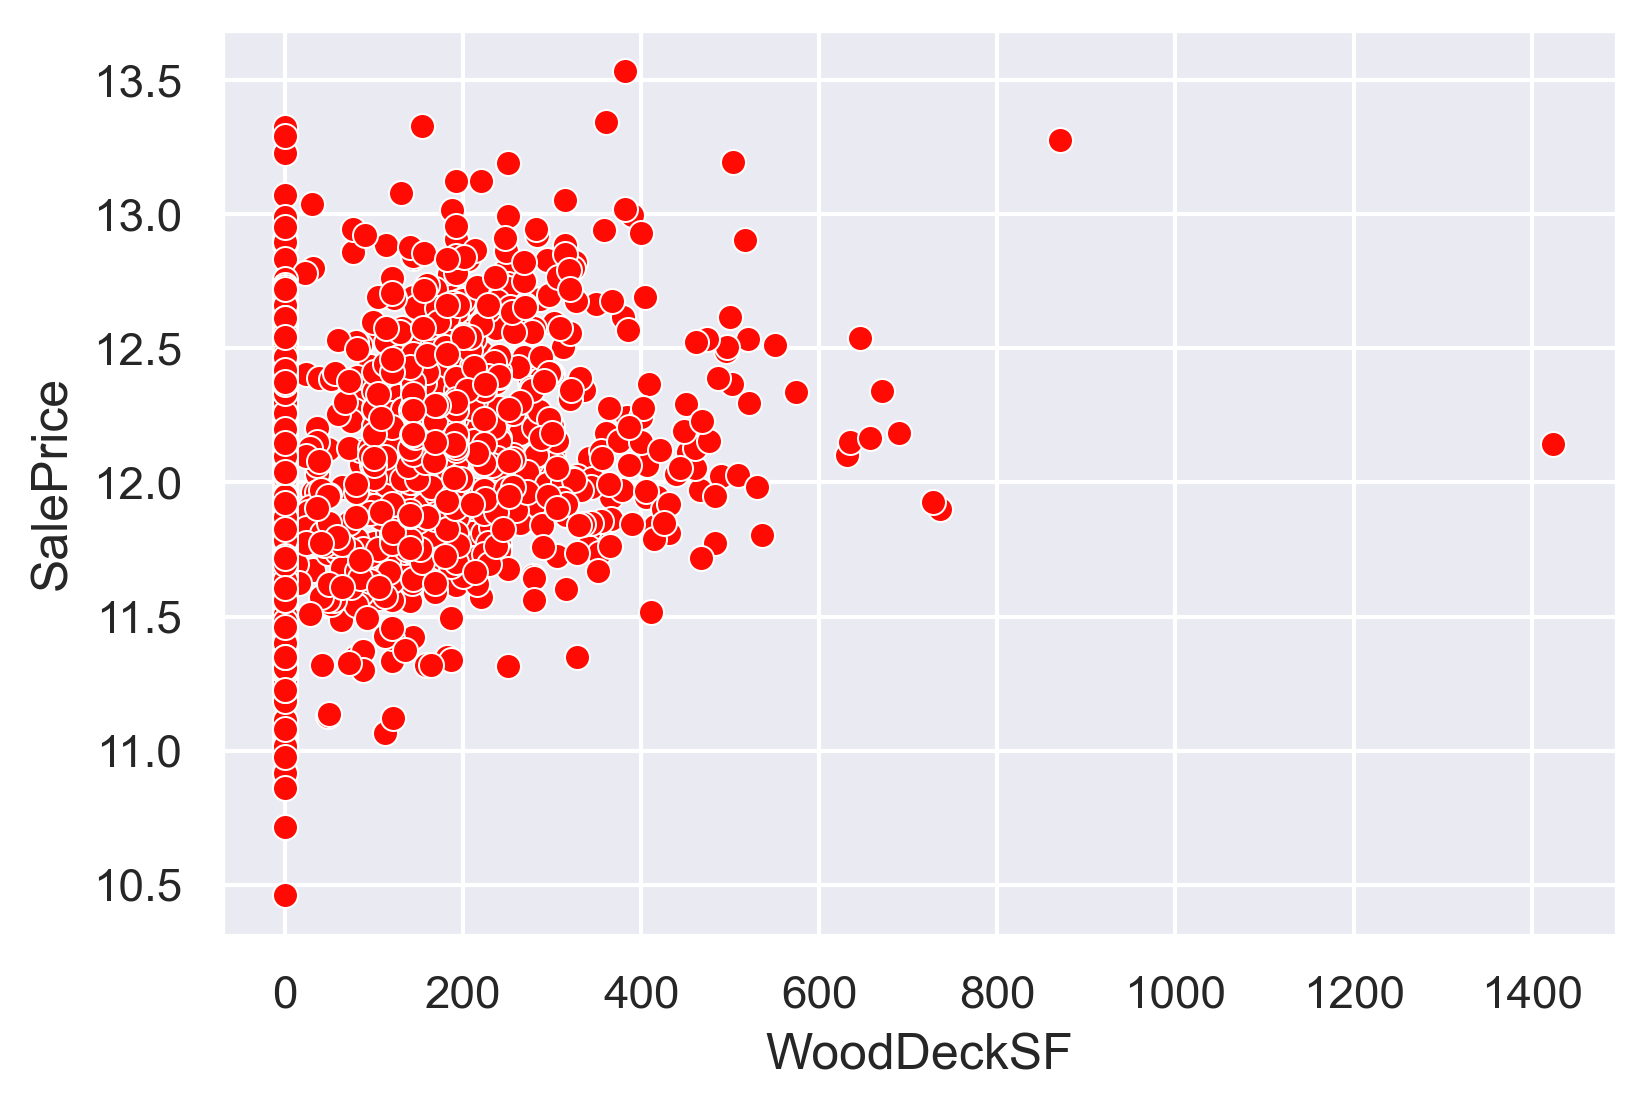

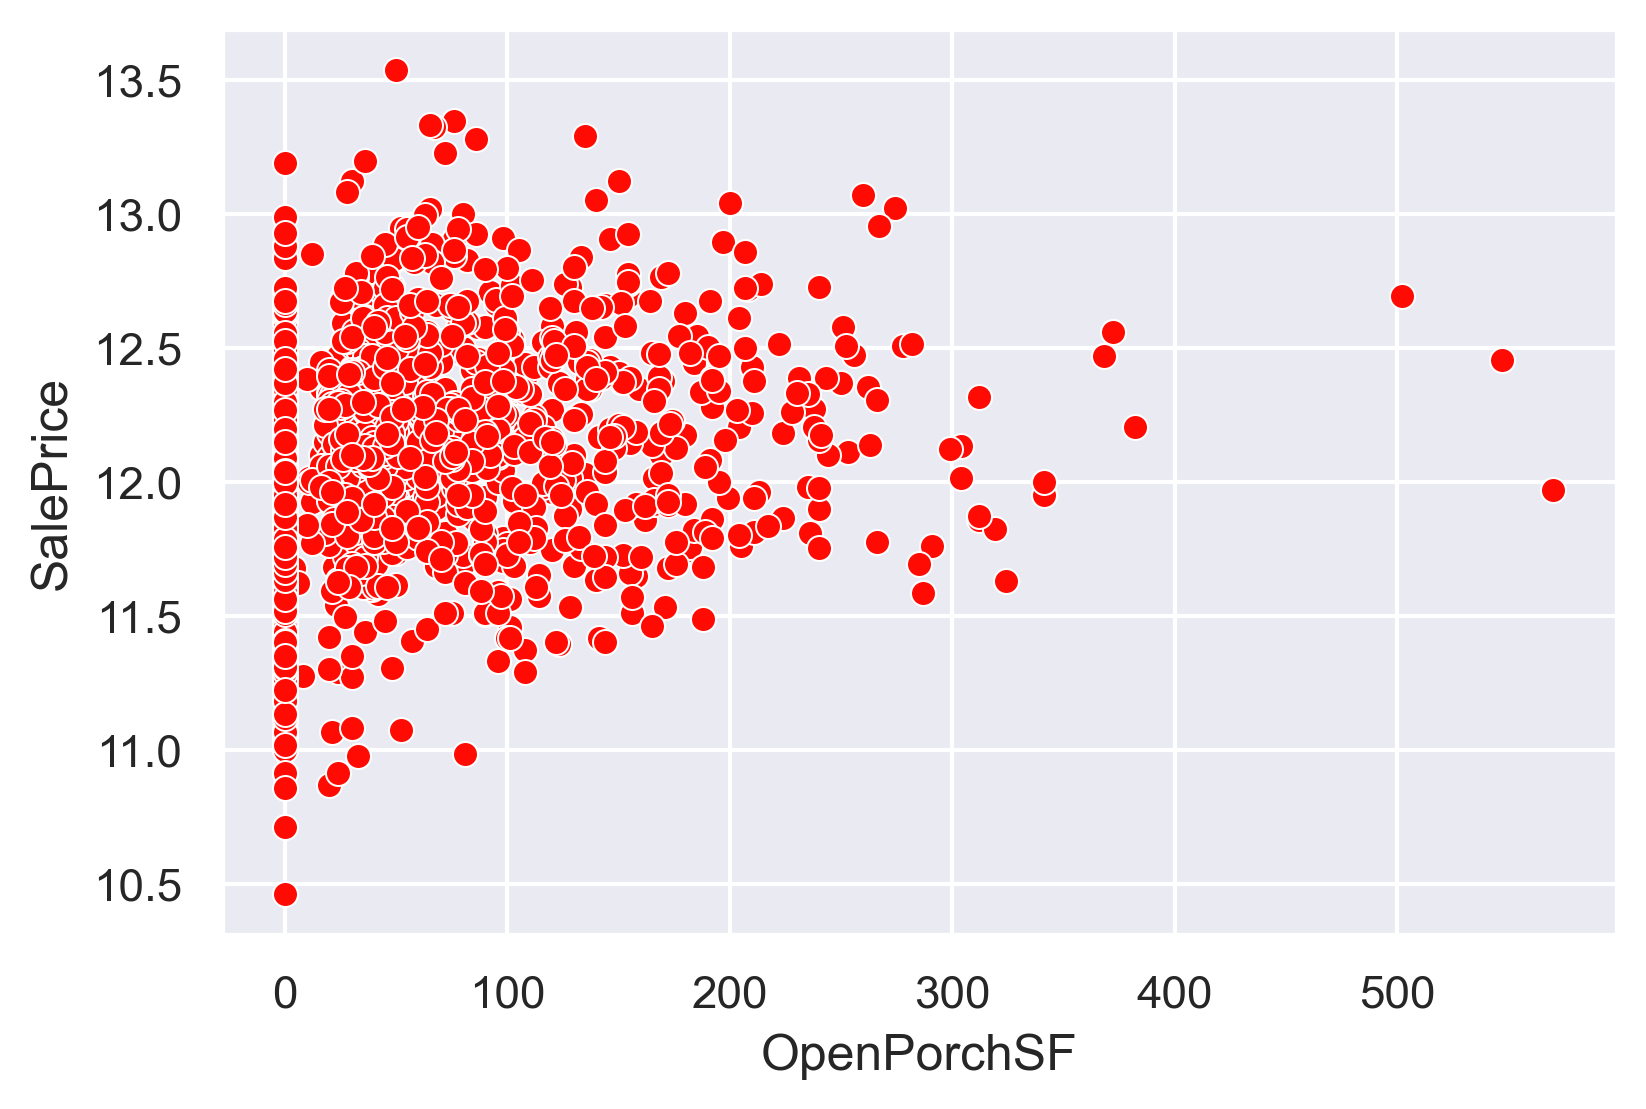

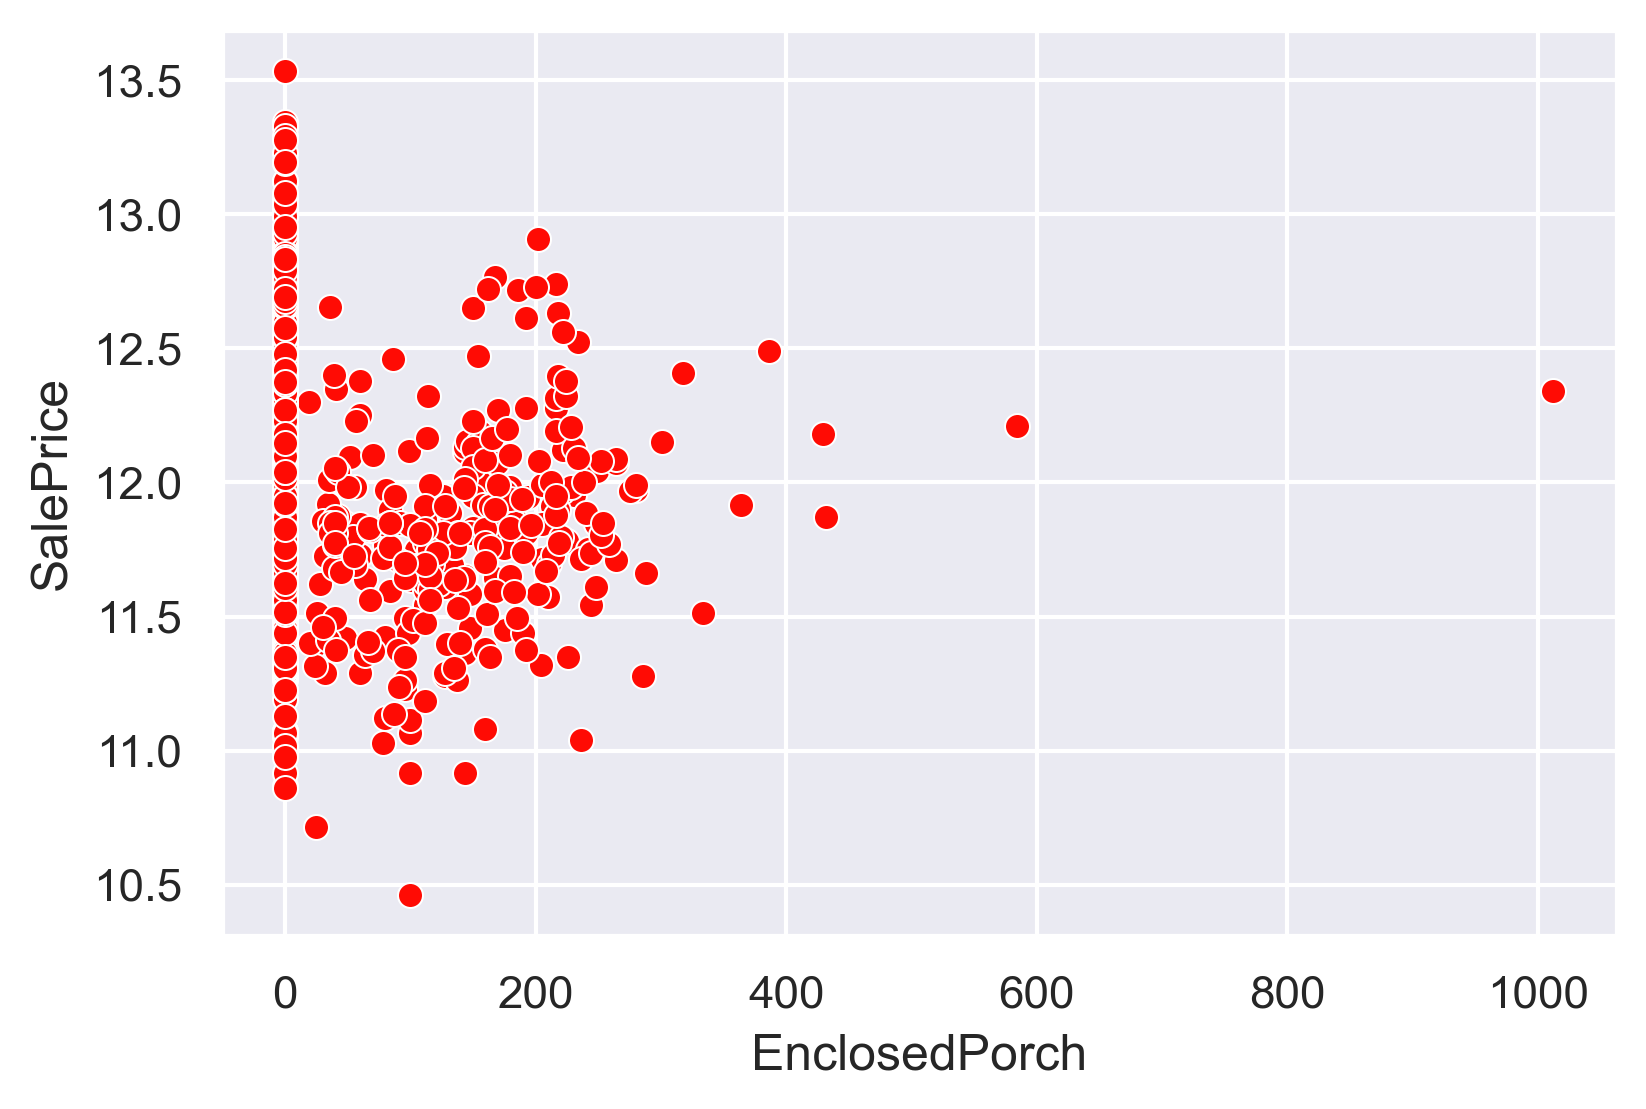

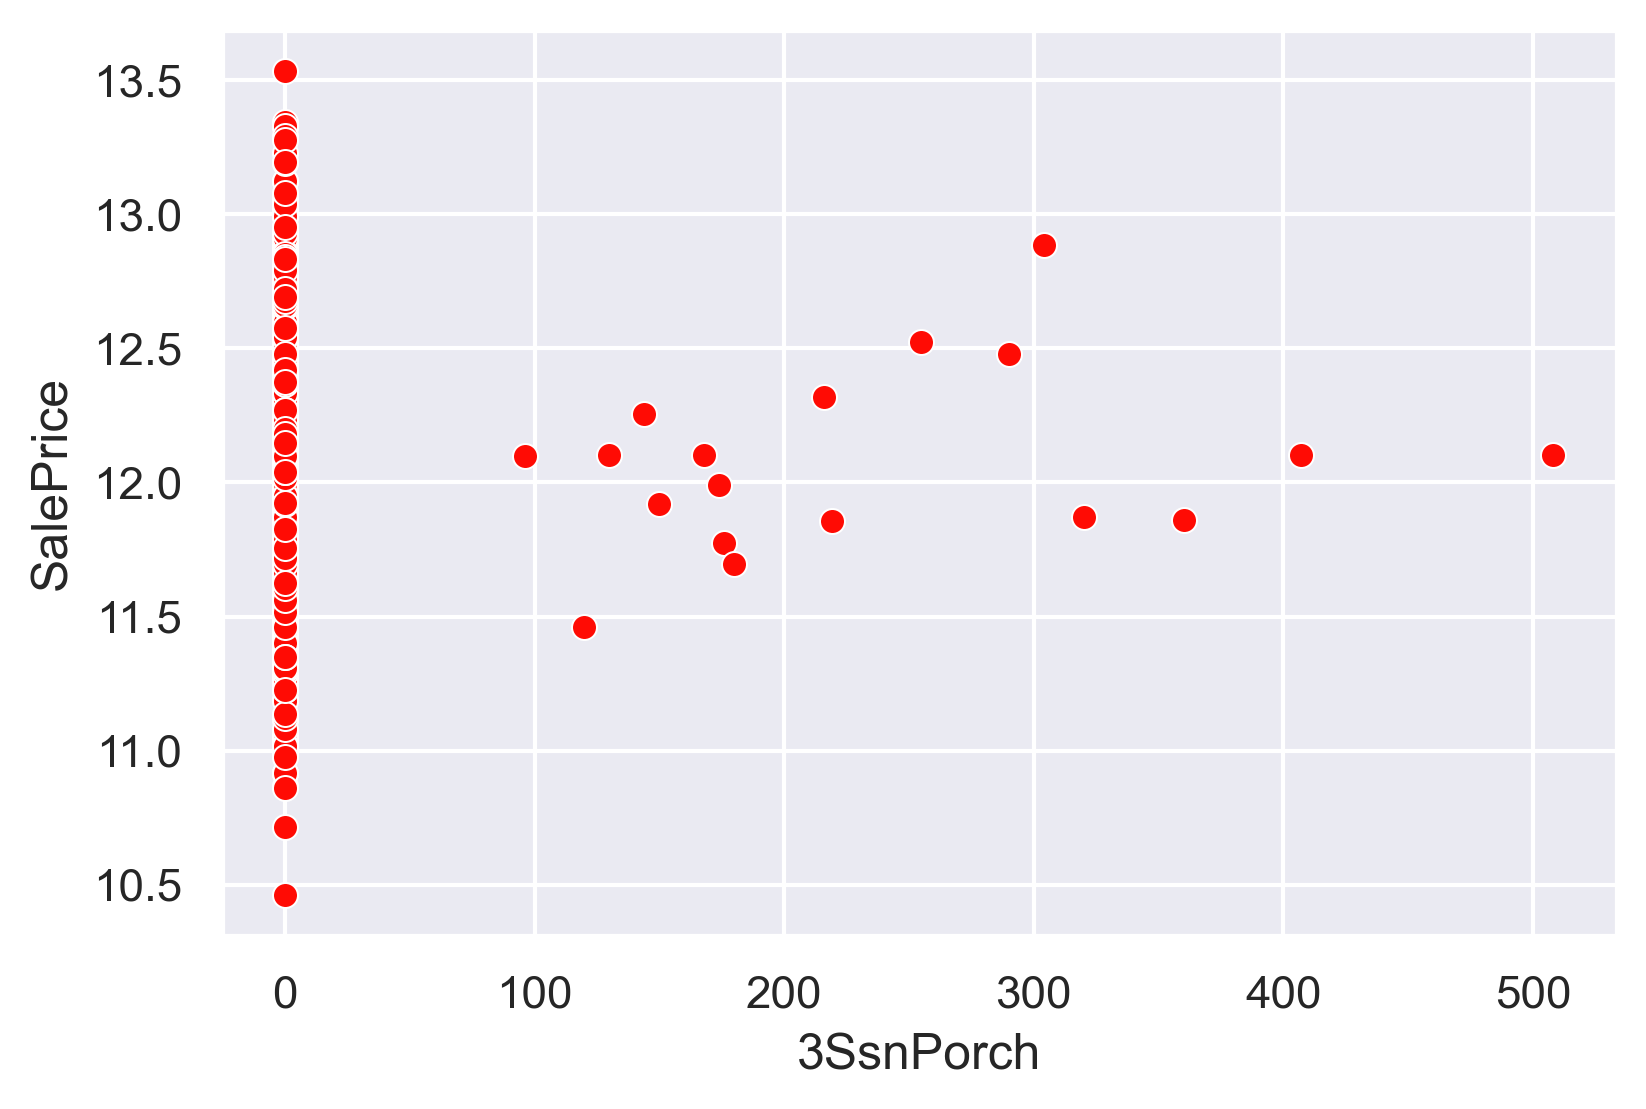

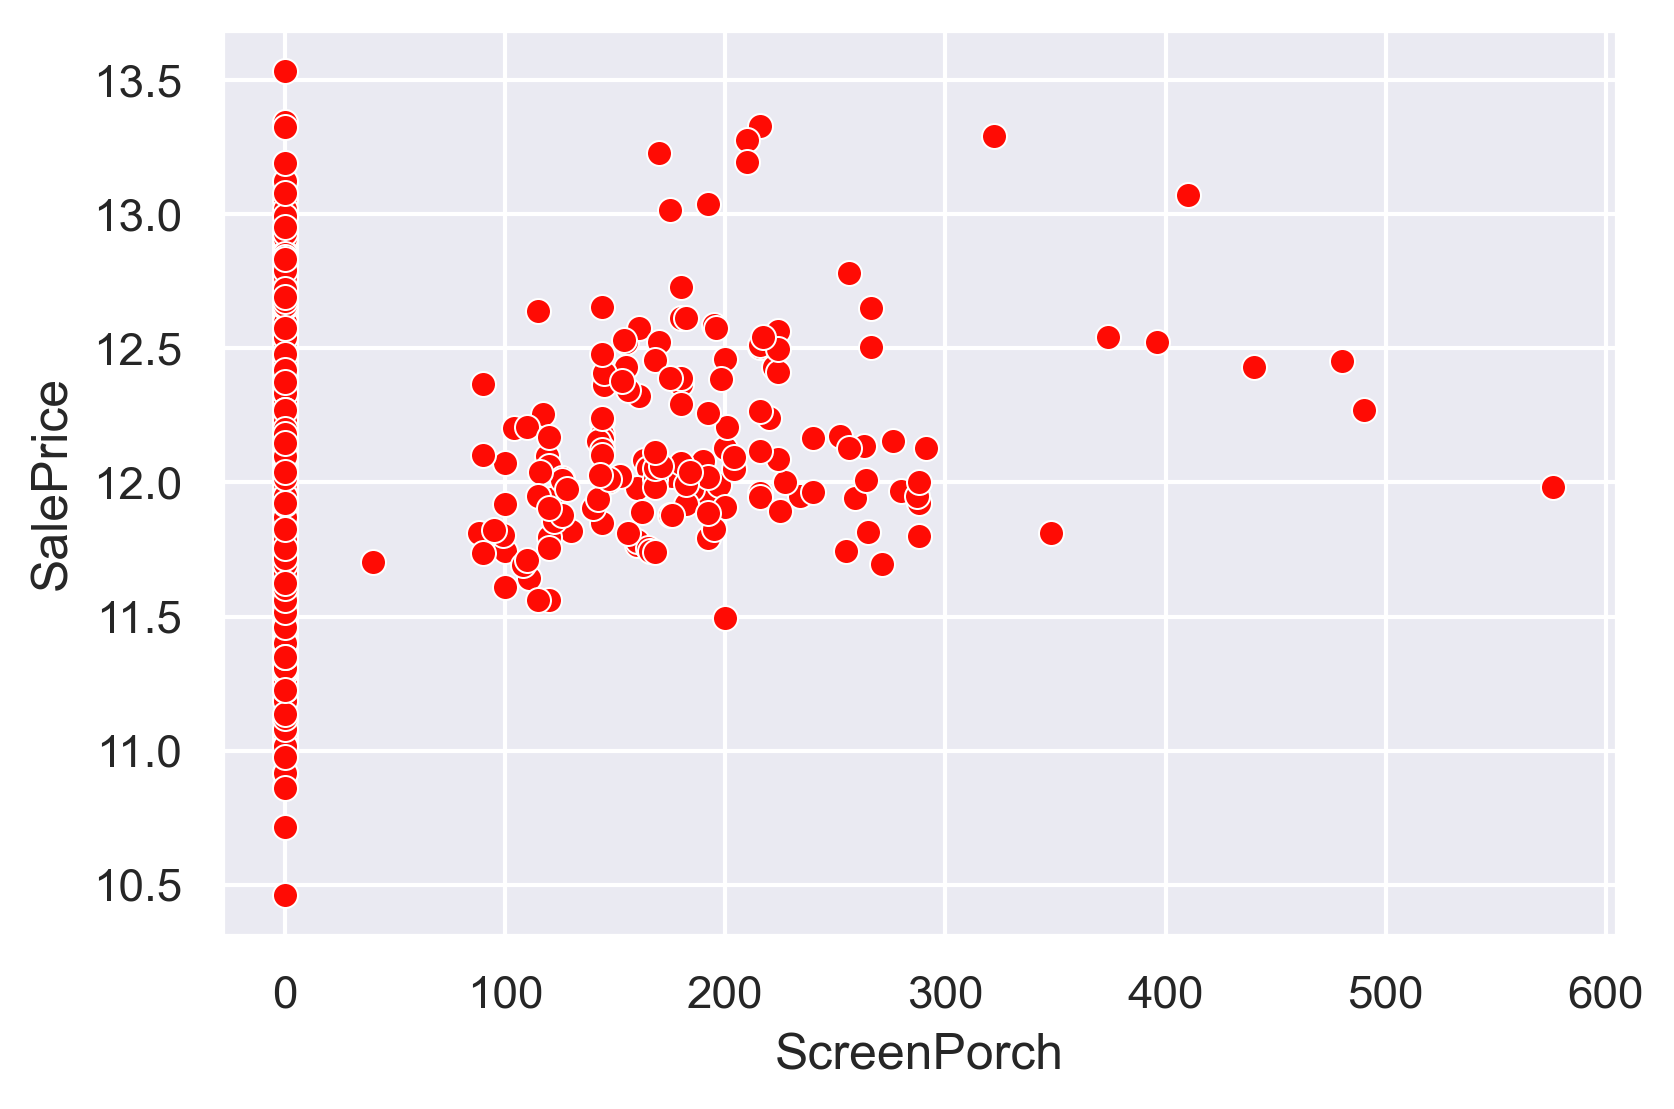

In [139]:
for name in myvar_dict['Porch']:
    x = hous_trn[name]
    y = np.log(hous_trn['SalePrice'])
    sns.scatterplot(x=x, y=y)
    plt.show()

### ^^ We see some outliers. What are the implications of so many values over zero?

In [141]:
# We try binarizing the Porch variables. 
for name in myvar_dict['Porch']:
    hous_trn[f'{name}_bool'] = hous_trn[name]>0

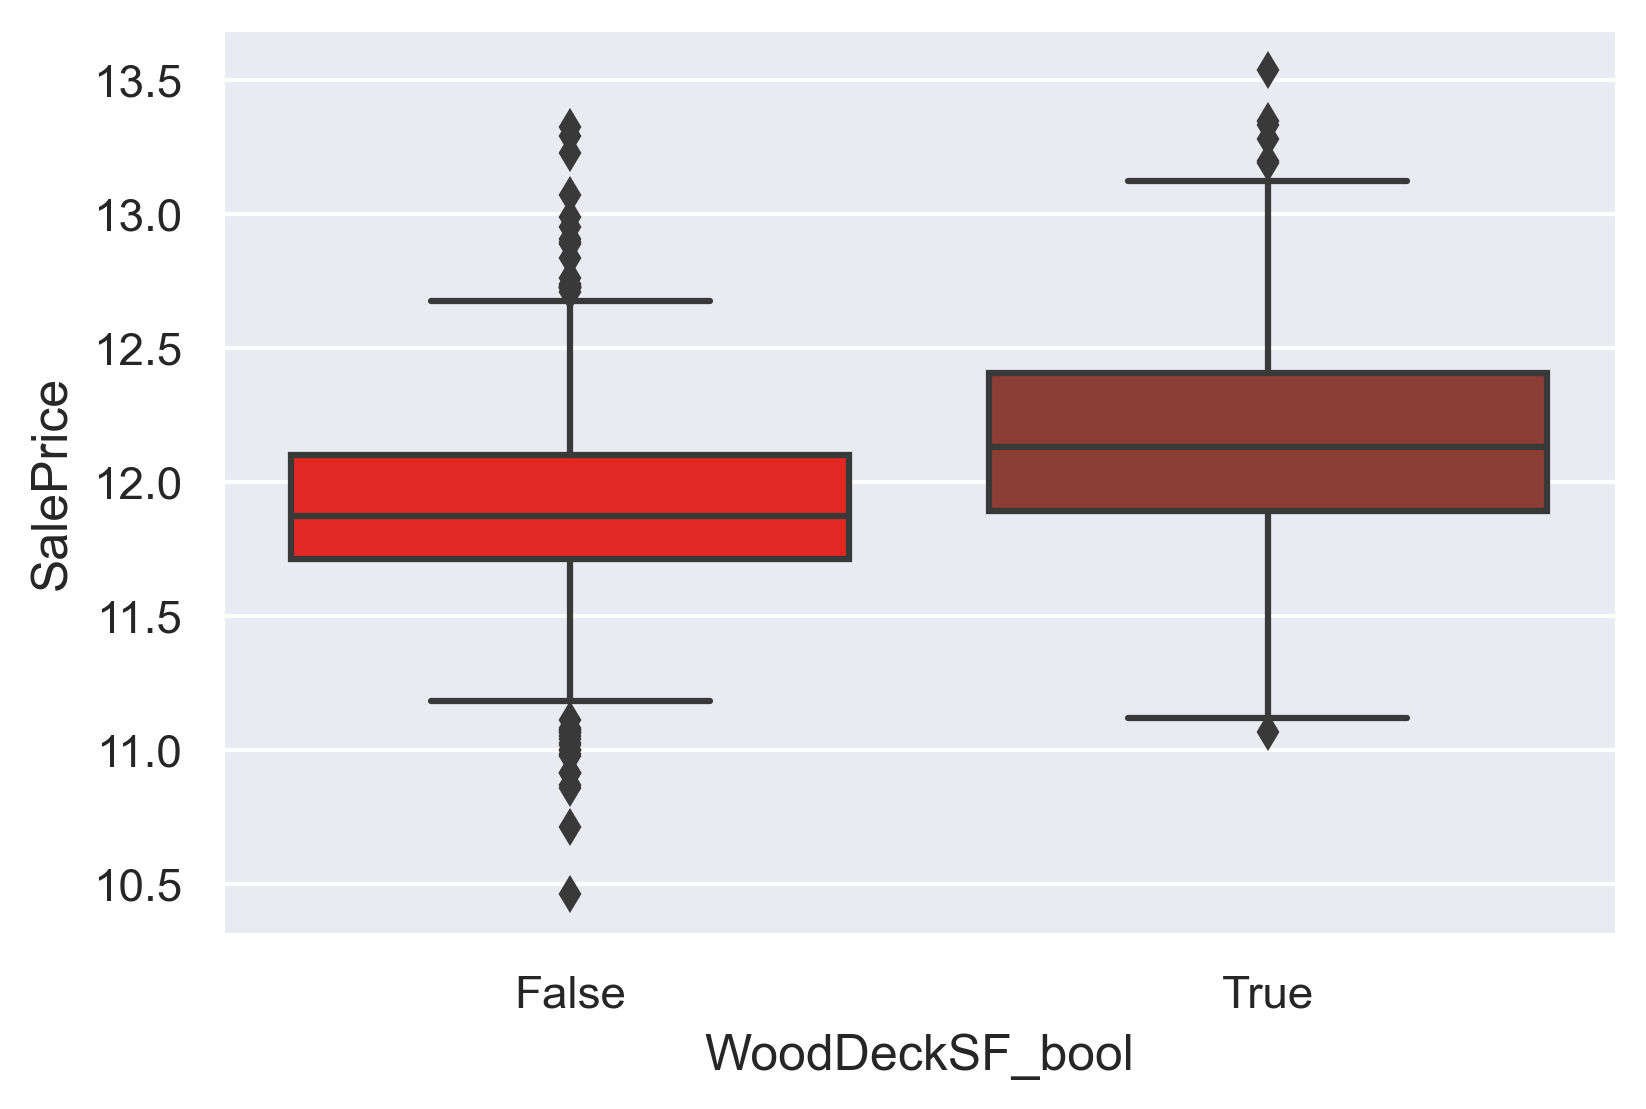

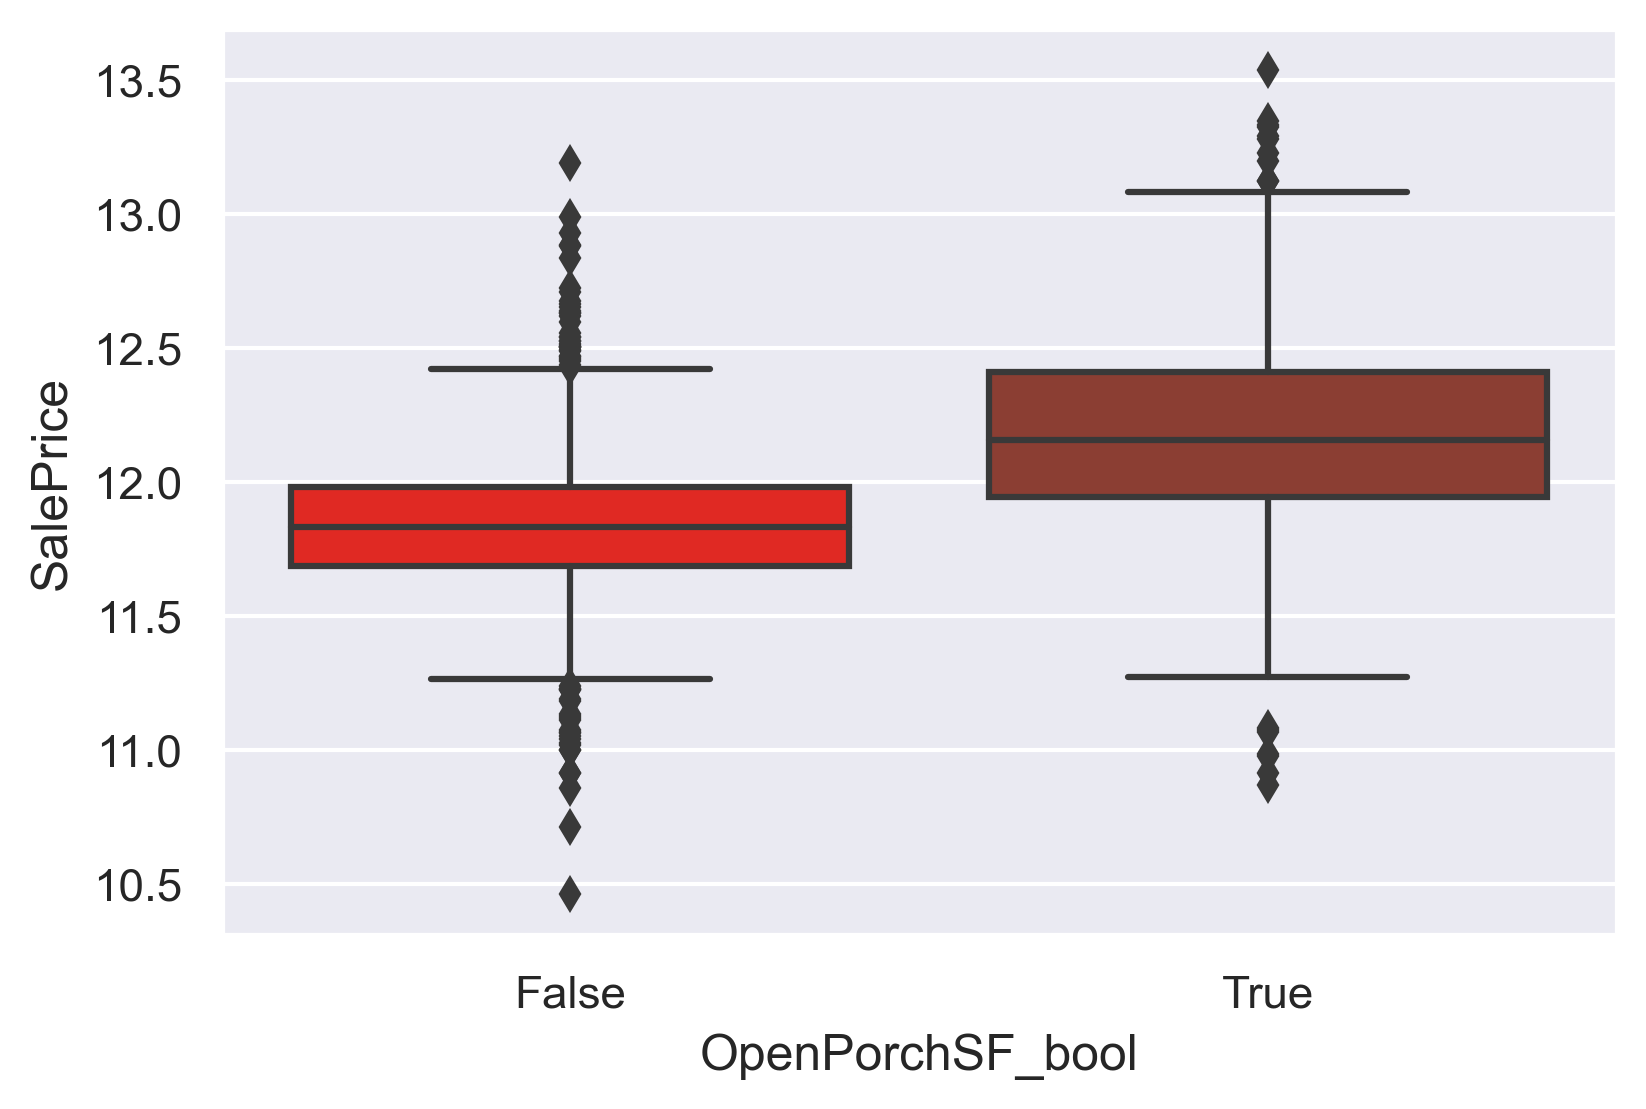

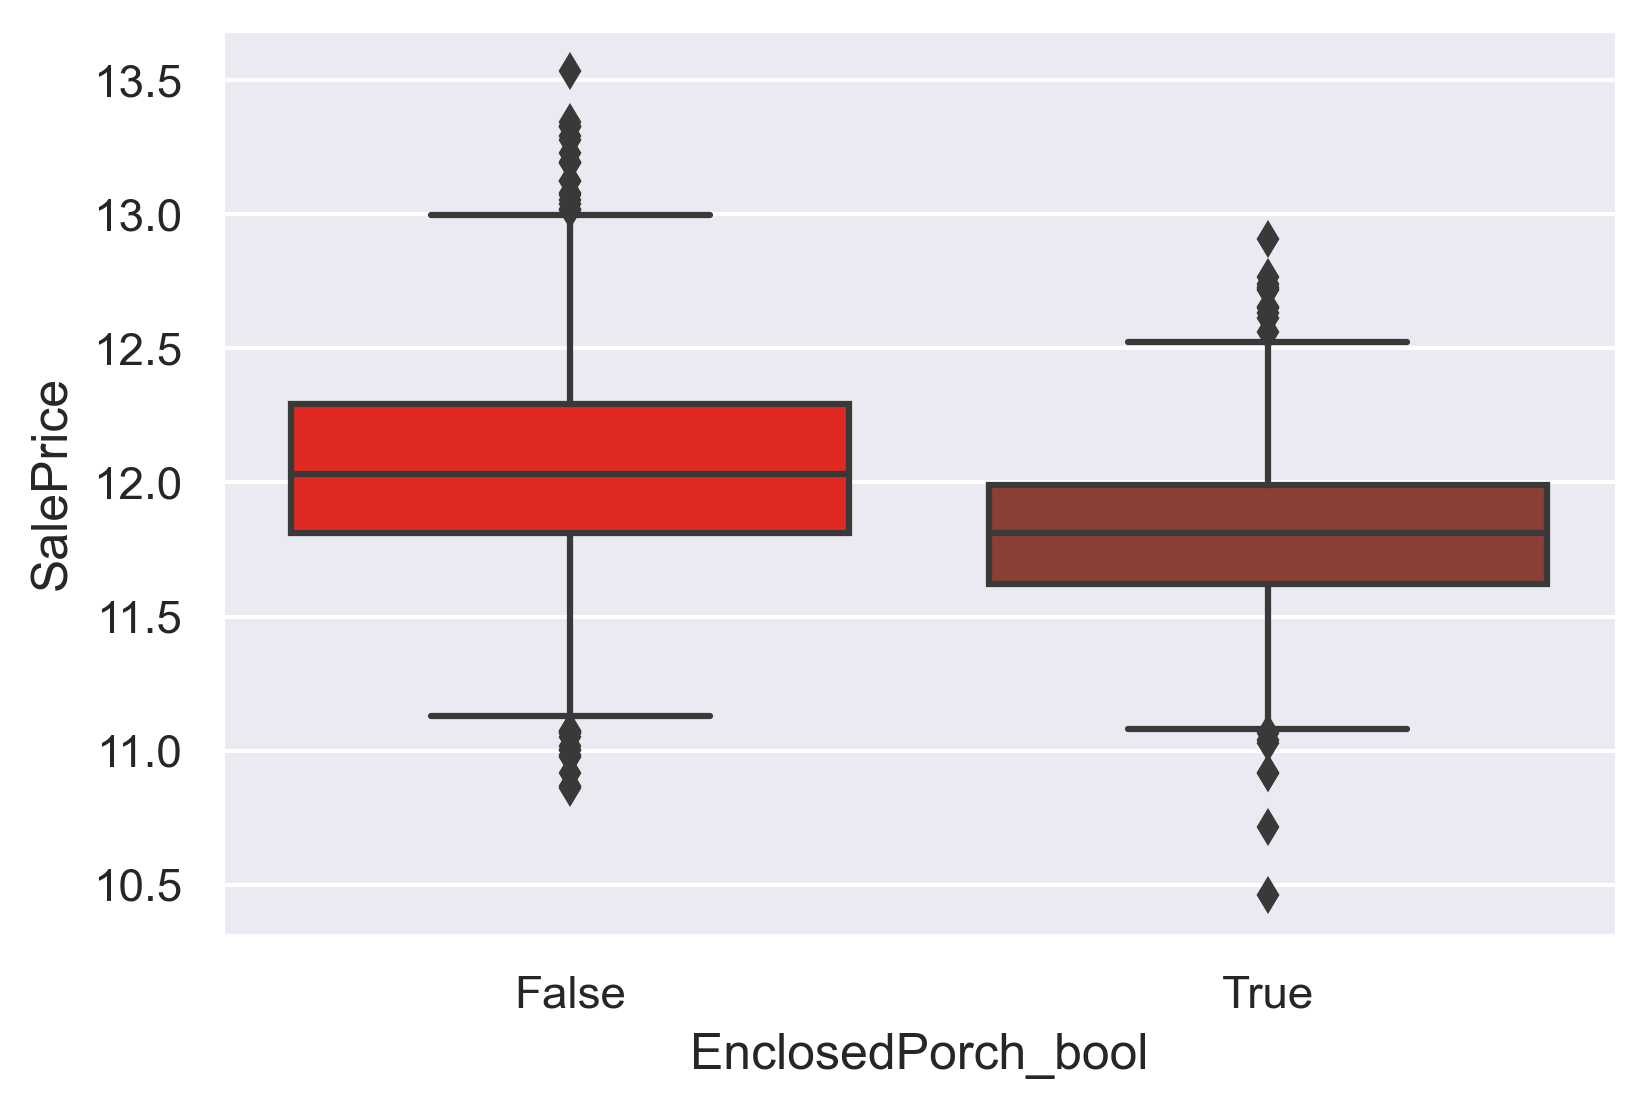

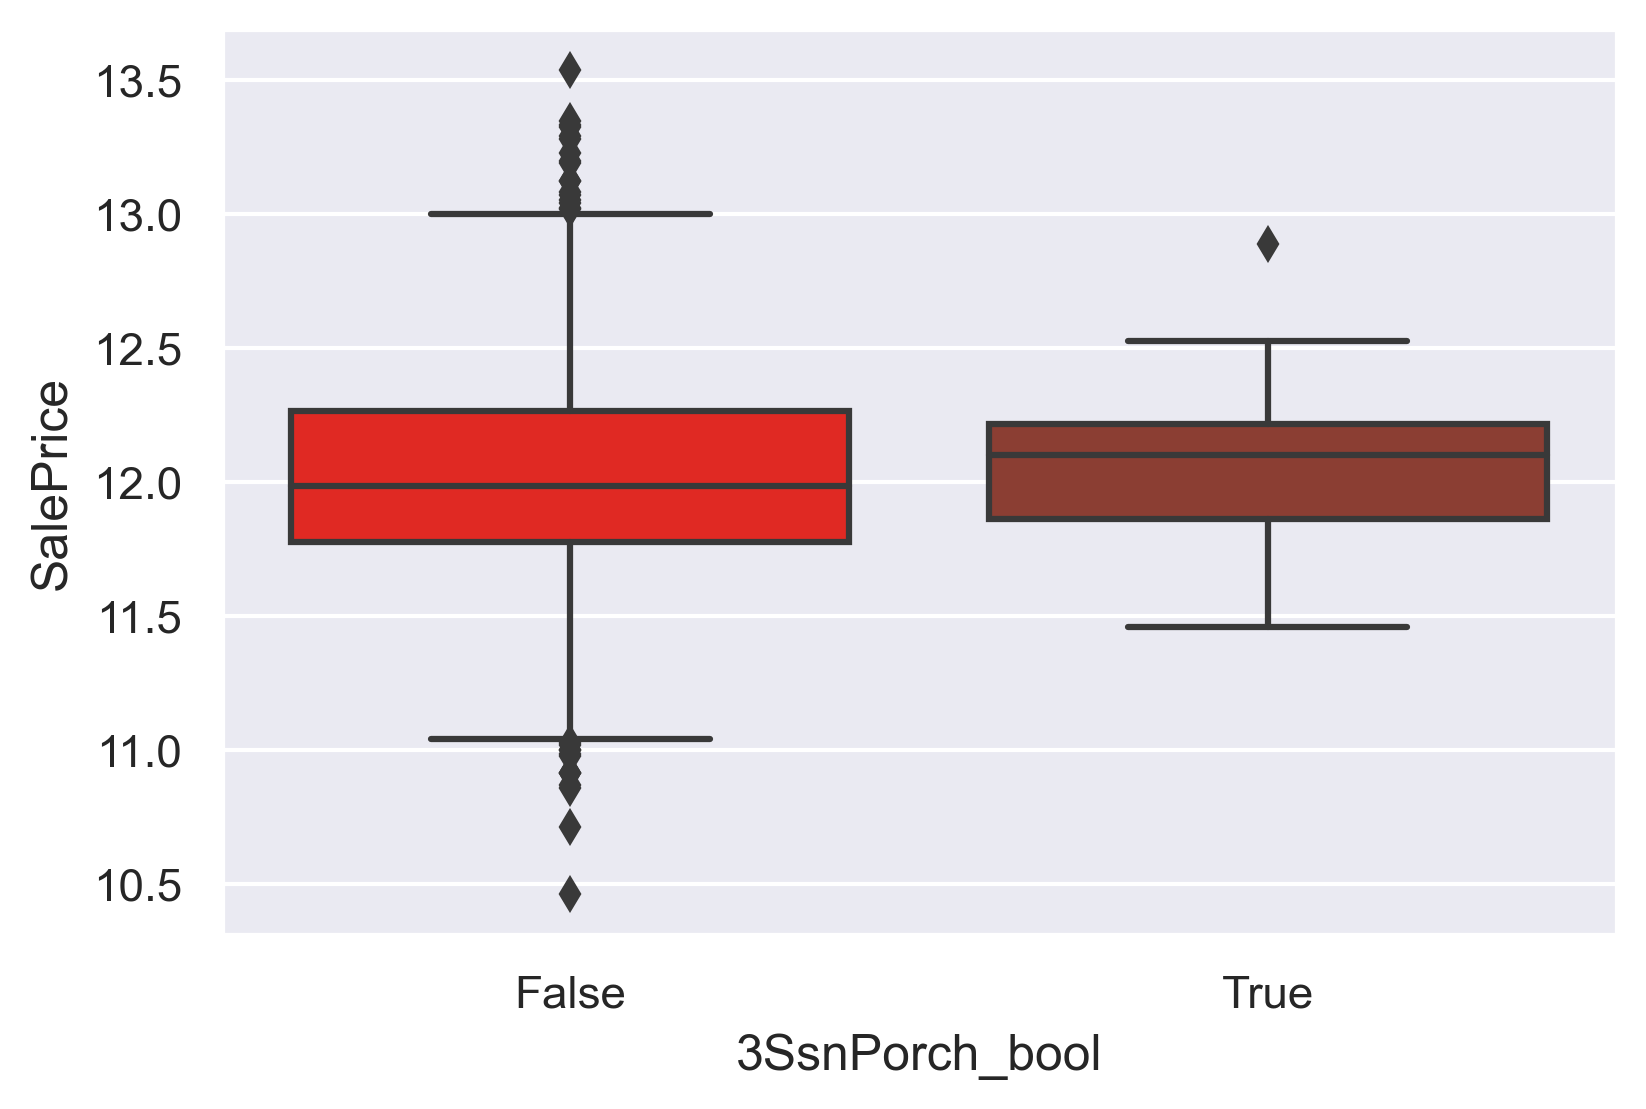

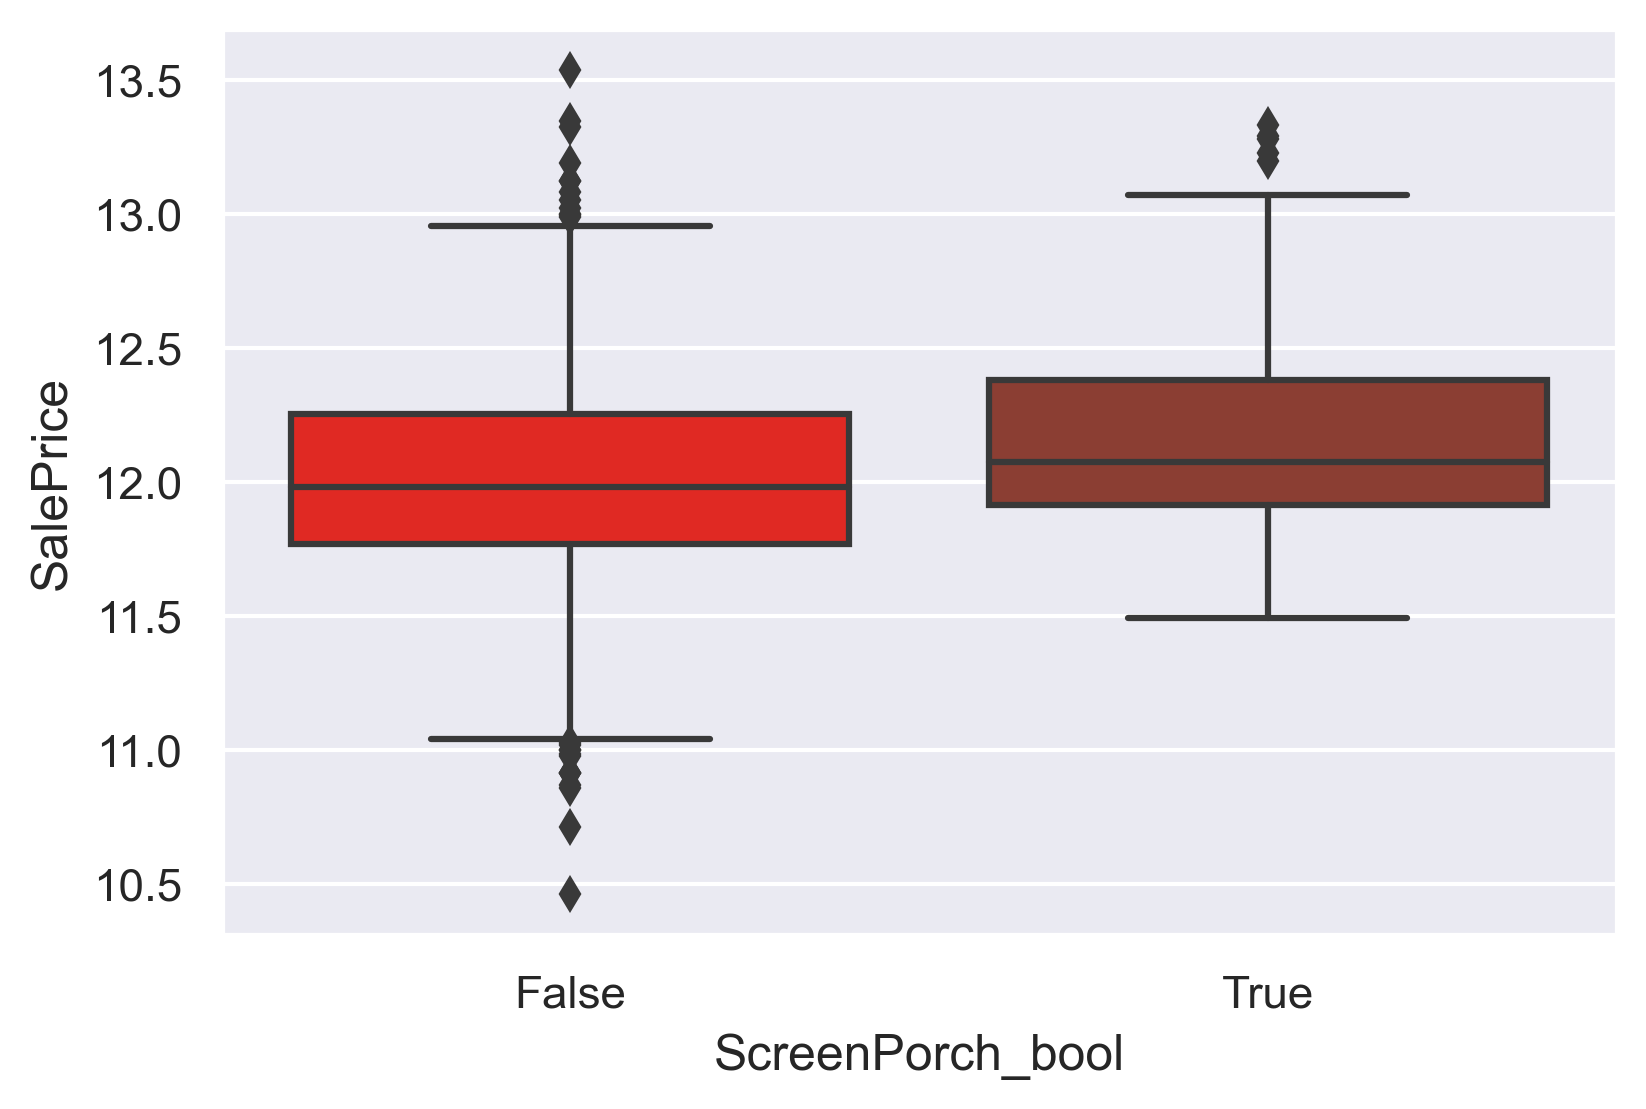

In [142]:
for name in myvar_dict['Porch']:
    x = hous_trn[f'{name}_bool']
    y = np.log(hous_trn['SalePrice'])
    sns.boxplot(x=x, y=y)
    plt.show()

In [70]:
hous_trn[myvar_dict['Basement']]

Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1  \
0          Slab     <NA>     <NA>         <NA>         <NA>         0.0   
1        CBlock       Gd       TA           Mn          ALQ       471.0   
2        CBlock       TA       TA           No          ALQ       276.0   
3        CBlock       TA       Fa           No          Rec       276.0   
4        CBlock       Gd       TA           Av          GLQ       773.0   
...         ...      ...      ...          ...          ...         ...   
1866      PConc       Gd       TA           No          Unf         0.0   
1867      PConc       Gd       TA           No          Unf         0.0   
1868     CBlock       Fa       TA           No          Unf         0.0   
1869      PConc       Gd       TA           No          GLQ       804.0   
1870      PConc       Gd       TA           No          GLQ       338.0   

     BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  \
0            <NA>         0.0        0.0          0.0             0   
1             Unf         0.0       90.0        561.0             1   
2             Unf         0.0      207.0        483.0             0   
3             Unf         0.0      252.0        528.0             0   
4             Unf         0.0      115.0        888.0             1   
...           ...         ...        ...          ...           ...   
1866          Unf         0.0      600.0        600.0             0   
1867          Unf         0.0     1082.0       1082.0             0   
1868          Unf         0.0      560.0        560.0             0   
1869          Unf         0.0      324.0       1128.0             1   
1870          Unf         0.0      292.0        630.0             0   

      BsmtHalfBath  
0                0  
1                0  
2                0  
3                0  
4                0  
...            ...  
1866             0  
1867             0  
1868             0  
1869             0  
1870             0  

[1871 rows x 12 columns]

In [16]:
bsmt_cols = [re.search('Bsmt', col) != None for col in hous_trn.columns]
hous_trn.loc[:,bsmt_cols]

BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  \
0          Gd       TA           No          GLQ       524.0          Unf   
1          TA       TA           No          LwQ       458.0          Unf   
2          TA       TA           No          ALQ       774.0          LwQ   
3          TA       TA           No          Rec       216.0          ALQ   
4          Gd       TA           No          ALQ       445.0          BLQ   
...       ...      ...          ...          ...         ...          ...   
1930       Gd       TA           No          Unf         0.0          Unf   
1931       TA       TA           No          Unf         0.0          Unf   
1932       Gd       TA           No          Unf         0.0          Unf   
1933       Gd       TA           No          BLQ      1128.0          Unf   
1934       Gd       TA           No          GLQ       338.0          Unf   

      BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  BsmtHalfBath  
0            0.0      628.0       1152.0             0             0  
1            0.0       25.0        483.0             0             1  
2          150.0      104.0       1028.0             1             0  
3          435.0      261.0        912.0             1             0  
4          250.0      412.0       1107.0             0             0  
...          ...        ...          ...           ...           ...  
1930         0.0     1264.0       1264.0             0             0  
1931         0.0      718.0        718.0             0             0  
1932         0.0     1288.0       1288.0             0             0  
1933         0.0      242.0       1370.0             1             0  
1934         0.0      292.0        630.0             0             0  

[1935 rows x 11 columns]

In [17]:
hous_trn[hous_trn['BsmtHalfBath'].isna()].loc[:,bsmt_cols]

BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  \
619      <NA>     <NA>         <NA>         <NA>         0.0         <NA>   
1825     <NA>     <NA>         <NA>         <NA>         NaN         <NA>   

      BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  BsmtHalfBath  
619          0.0        0.0          0.0          <NA>          <NA>  
1825         NaN        NaN          NaN          <NA>          <NA>

In [18]:
hous_trn.iloc[[1825]]

PID  GrLivArea  SalePrice  MSSubClass MSZoning  LotFrontage  \
1825  903230120        896      79000          20       RM         99.0   

      LotArea Street Alley LotShape  ... ScreenPorch PoolArea PoolQC  Fence  \
1825   5940.0   Pave   NaN      IR1  ...         0.0        0    NaN  MnPrv   

     MiscFeature MiscVal MoSold YrSold SaleType  SaleCondition  
1825         NaN       0      4   2008    ConLD        Abnorml  

[1 rows x 81 columns]

In [19]:
hous_trn[(hous_trn['TotalBsmtSF'].isna()) | (hous_trn['TotalBsmtSF']==0)].shape

(56, 81)

In [20]:
bsmt_df1 = hous_trn[(hous_trn['TotalBsmtSF'].isna()) | (hous_trn['TotalBsmtSF']==0)]

In [21]:
hous_trn[hous_trn['BsmtQual'].isna()].shape

(56, 81)

In [22]:
bsmt_df2 = hous_trn[hous_trn['BsmtQual'].isna()]

In [23]:
bsmt_df3 = bsmt_df1.merge(bsmt_df2, how='outer', indicator=True)
bsmt_df3[bsmt_df3['_merge']!='both']

Empty DataFrame
Columns: [PID, GrLivArea, SalePrice, MSSubClass, MSZoning, LotFrontage, LotArea, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, PoolQC, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, _merge]
Index: []

[0 rows x 82 columns]

In [24]:
hous_trn[(hous_trn['BsmtQual'].isna()) & (hous_trn['TotalBsmtSF']!=0)].loc[:,[re.search('Bsmt', col) != None for col in hous_trn.columns]].shape

(1, 11)

In [25]:
hous_trn['BsmtQual'].unique()

<StringArray>
['Gd', 'TA', <NA>, 'Ex', 'Fa', 'Po']
Length: 6, dtype: string

In [26]:
hous_trn = hous_trn.fillna(value={'BsmtQual':'None'})

In [27]:
hous_trn['BsmtQual'].unique()

<StringArray>
['Gd', 'TA', 'None', 'Ex', 'Fa', 'Po']
Length: 6, dtype: string

In [28]:
BsmtQual_dict = {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}

In [29]:
hous_trn['BQ_score'] = [BsmtQual_dict[cell] for cell in hous_trn['BsmtQual']]

In [30]:
hous_trn['BsmtCond'].unique()

<StringArray>
['TA', 'Fa', <NA>, 'Gd', 'Ex', 'Po']
Length: 6, dtype: string

In [31]:
hous_trn = hous_trn.fillna(value={'BsmtCond':'None'})

In [32]:
hous_trn['BsmtCond'].unique()

<StringArray>
['TA', 'Fa', 'None', 'Gd', 'Ex', 'Po']
Length: 6, dtype: string

In [33]:
BsmtCond_dict = {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}

In [34]:
hous_trn['BC_score'] = [BsmtCond_dict[cell] for cell in hous_trn['BsmtCond']]

In [35]:
hous_trn['BsmtExposure'].unique()

<StringArray>
['No', 'Av', 'Mn', <NA>, 'Gd']
Length: 5, dtype: string

In [36]:
hous_trn = hous_trn.fillna(value={'BsmtExposure':'None'})

In [37]:
hous_trn['BsmtExposure'].unique()

<StringArray>
['No', 'Av', 'Mn', 'None', 'Gd']
Length: 5, dtype: string

In [38]:
BsmtExp_dict = {'None':0, 'No':0, 'Mn':1, 'Av':2, 'Gd':3}

In [39]:
hous_trn['BE_score'] = [BsmtExp_dict[cell] for cell in hous_trn['BsmtExposure']]

In [40]:
hous_trn['BsmtFinType1'].unique()

<StringArray>
['GLQ', 'LwQ', 'ALQ', 'Rec', 'Unf', <NA>, 'BLQ']
Length: 7, dtype: string

In [41]:
hous_trn = hous_trn.fillna(value={'BsmtFinType1':'None'})

In [42]:
BsmtFT1_dict = {'None':0, 'Unf':0, 'LwQ':1, 'Rec':2, 'BLQ':3, 'ALQ':4, 'GLQ':5}

In [43]:
hous_trn['BFT1_score'] = [BsmtFT1_dict[cell] for cell in hous_trn['BsmtFinType1']]

In [44]:
hous_trn['BsmtFinType2'].unique()

<StringArray>
['Unf', 'LwQ', 'ALQ', 'BLQ', <NA>, 'Rec', 'GLQ']
Length: 7, dtype: string

In [45]:
hous_trn = hous_trn.fillna(value={'BsmtFinType2':'None'})

In [46]:
BsmtFT2_dict = BsmtFT1_dict

In [47]:
hous_trn['BFT2_score'] = [BsmtFT2_dict[cell] for cell in hous_trn['BsmtFinType2']]

In [48]:
hous_trn = hous_trn.fillna(value={'BsmtFinSF1':0, 'BsmtFinSF2':0, 'BsmtUnfSF':0, 'TotalBsmtSF':0})

In [49]:
hous_trn['TotalBsmtSF_calc'] = hous_trn['BsmtFinSF1'] + hous_trn['BsmtFinSF2'] + hous_trn['BsmtUnfSF']

In [50]:
hous_trn.loc[:,['TotalBsmtSF','TotalBsmtSF_calc']]

TotalBsmtSF  TotalBsmtSF_calc
0          1152.0            1152.0
1           483.0             483.0
2          1028.0            1028.0
3           912.0             912.0
4          1107.0            1107.0
...           ...               ...
1930       1264.0            1264.0
1931        718.0             718.0
1932       1288.0            1288.0
1933       1370.0            1370.0
1934        630.0             630.0

[1935 rows x 2 columns]

In [51]:
hous_trn[hous_trn['TotalBsmtSF']!=hous_trn['TotalBsmtSF_calc']]

Empty DataFrame
Columns: [PID, GrLivArea, SalePrice, MSSubClass, MSZoning, LotFrontage, LotArea, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, PoolQC, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, BQ_score, BC_score, BE_score, BFT1_score, BFT2_score, TotalBsmtSF_calc]
Index: []

[0 rows x 87 columns]

In [52]:
hous_trn[(hous_trn['BQ_score']!=0) & (hous_trn['TotalBsmtSF']==0)]

Empty DataFrame
Columns: [PID, GrLivArea, SalePrice, MSSubClass, MSZoning, LotFrontage, LotArea, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, PoolQC, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, BQ_score, BC_score, BE_score, BFT1_score, BFT2_score, TotalBsmtSF_calc]
Index: []

[0 rows x 87 columns]

In [53]:
BQ_score = hous_trn['BQ_score']
BC_score = hous_trn['BC_score']
BE_score = hous_trn['BE_score']
BsmtFinSF1 = hous_trn['BsmtFinSF1']
BsmtFinSF2 = hous_trn['BsmtFinSF2']
TotalBsmtSF = hous_trn['TotalBsmtSF']
BFT1_score = hous_trn['BFT1_score']
BFT2_score = hous_trn['BFT2_score']

new_col = []
for i in range(len(hous_trn)):
    if BQ_score[i] == 0:
        new_col.append(0)
    else:
        new_col.append(
            BQ_score[i] * (
                (1 + BC_score[i]/10)*(1 + BE_score[i]/10)*(
                    1 + ((BsmtFinSF1[i] + BsmtFinSF2[i])/TotalBsmtSF[i])*(1 + BFT1_score[i]/10)*(1 + BFT2_score[i]/100)
                )
            )
        )
    
hous_trn['BsmtScore'] = new_col

In [54]:
hous_trn['BsmtScore'].describe()

count    1935.000000
mean        8.088807
std         4.017244
min         0.000000
25%         5.200000
50%         7.414548
75%        10.722397
max        20.904805
Name: BsmtScore, dtype: float64

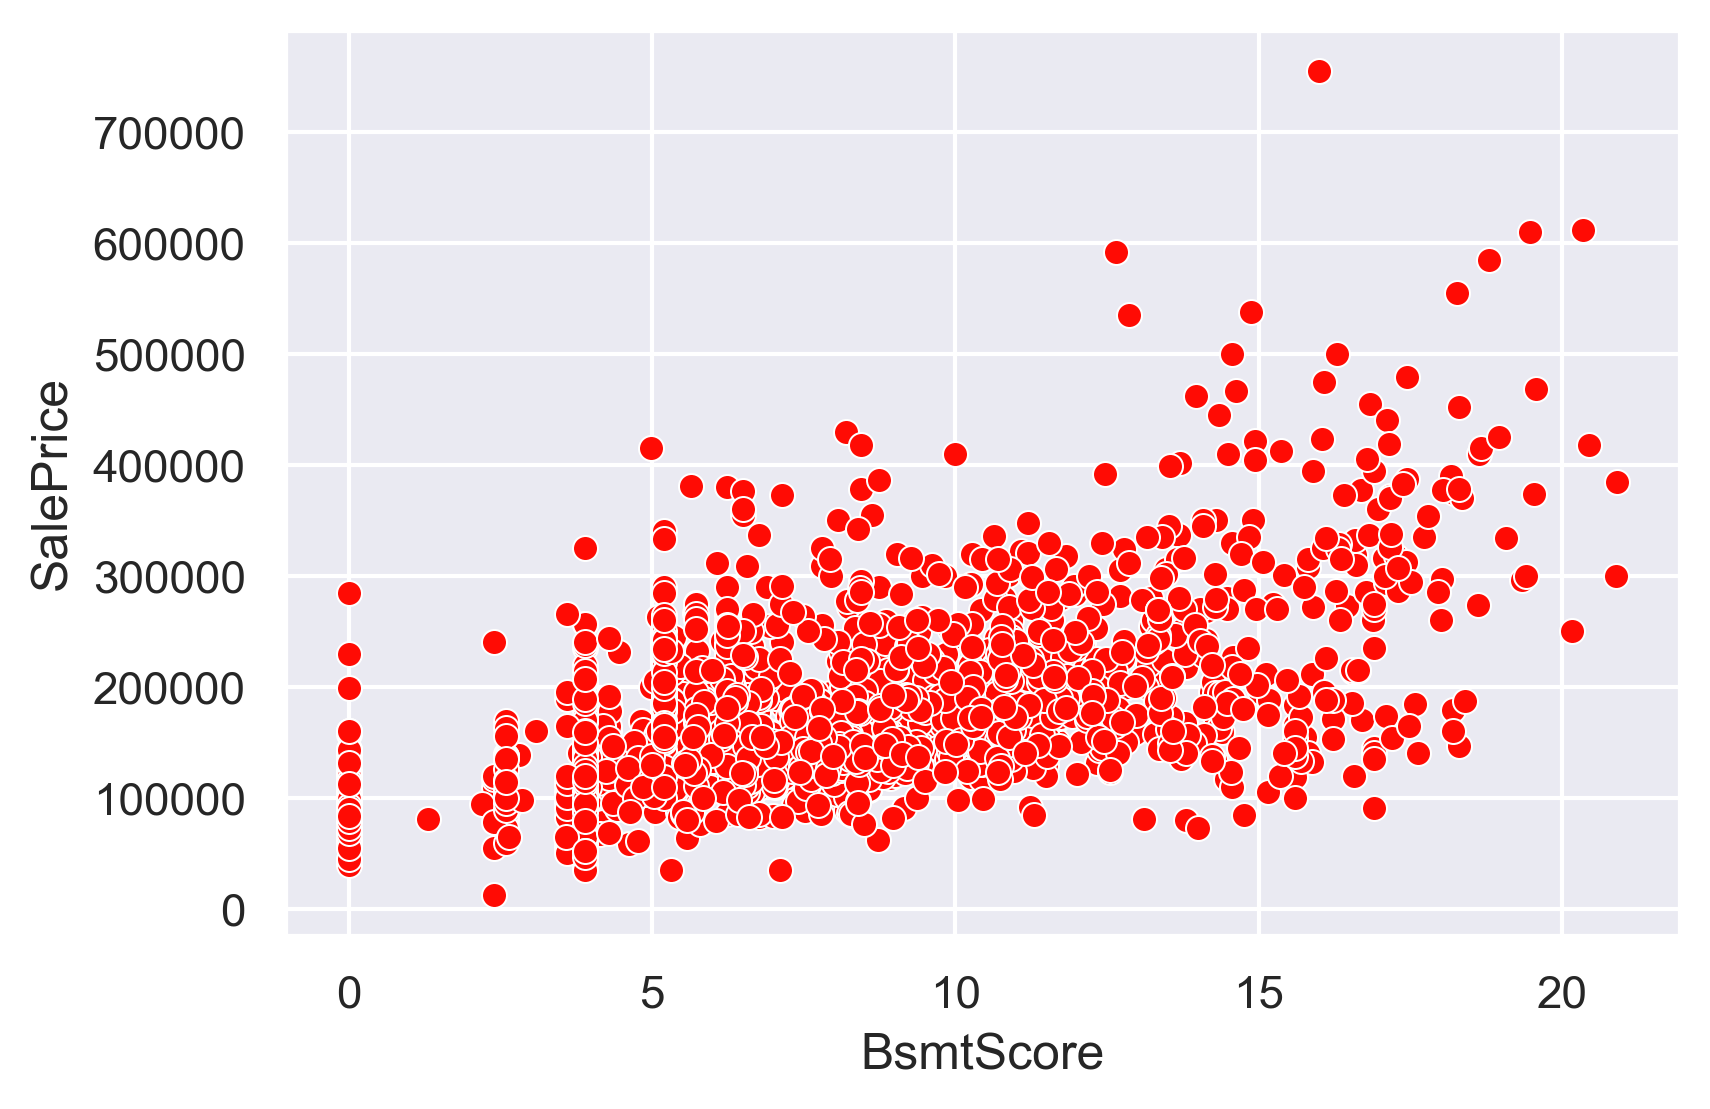

In [55]:
x = hous_trn['BsmtScore']
y = hous_trn['SalePrice']
sns.scatterplot(x=x, y=y)
plt.show()

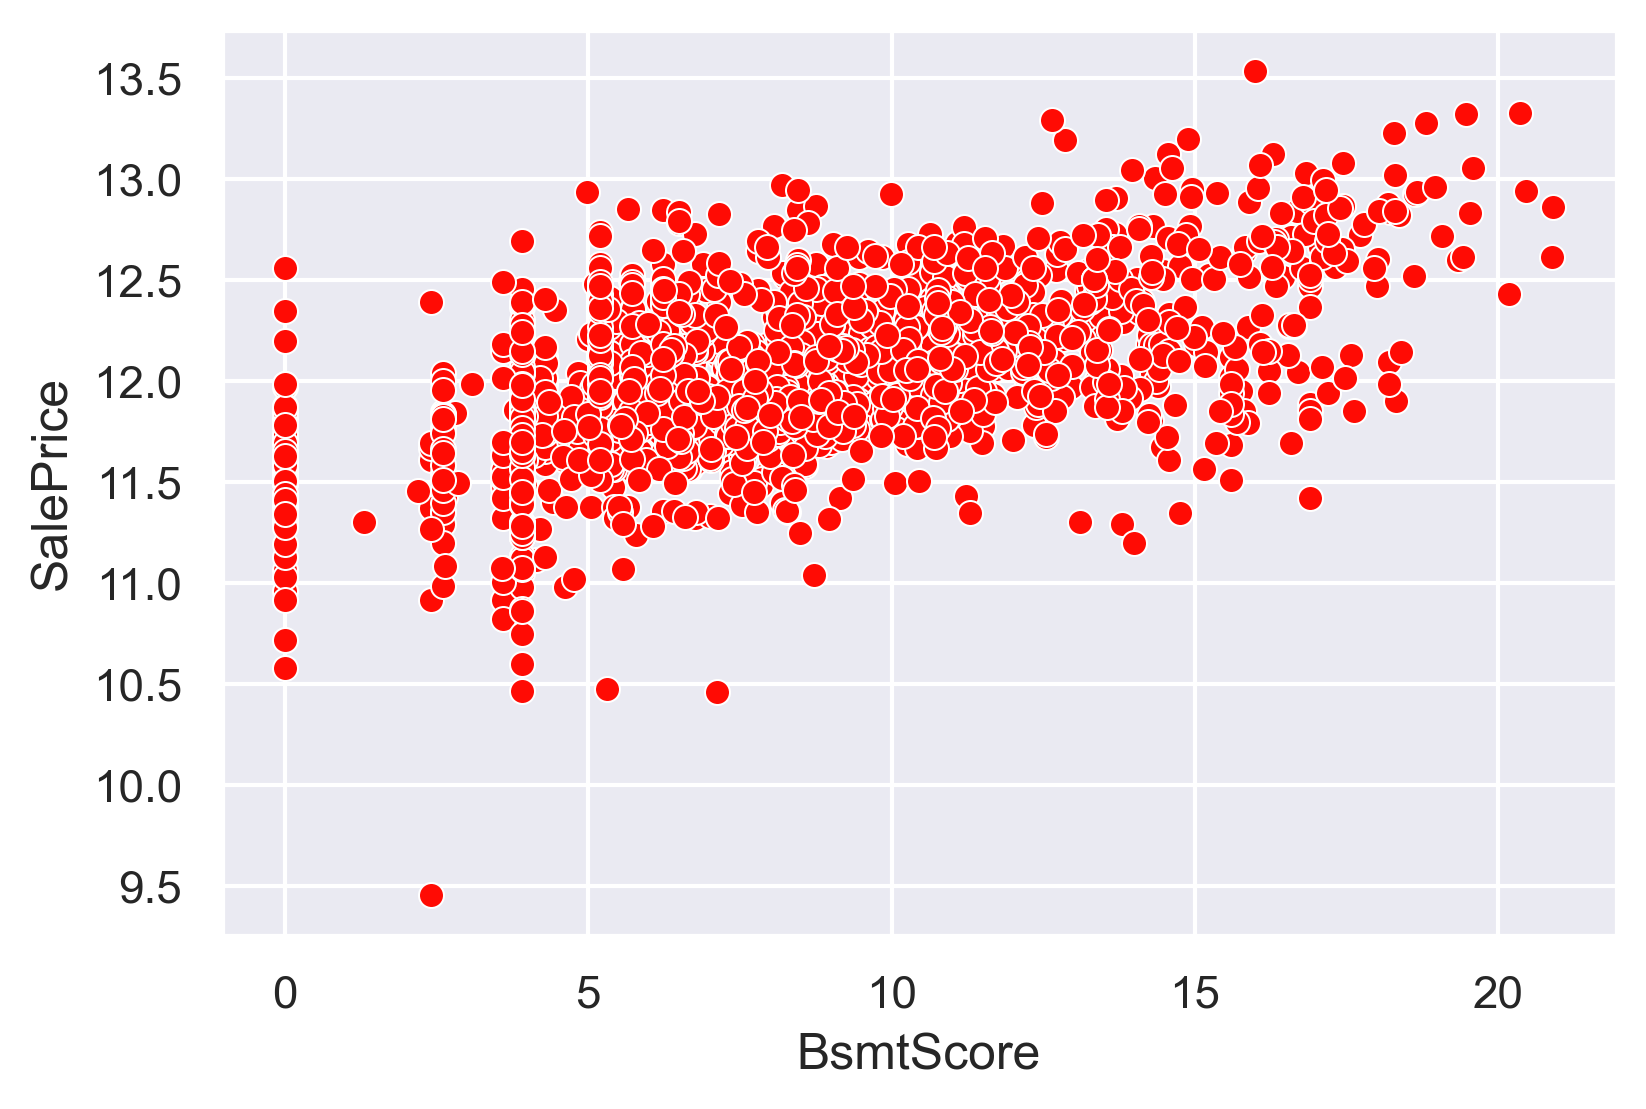

In [56]:
x = hous_trn['BsmtScore']
y = np.log(hous_trn['SalePrice'])
sns.scatterplot(x=x, y=y)
plt.show()

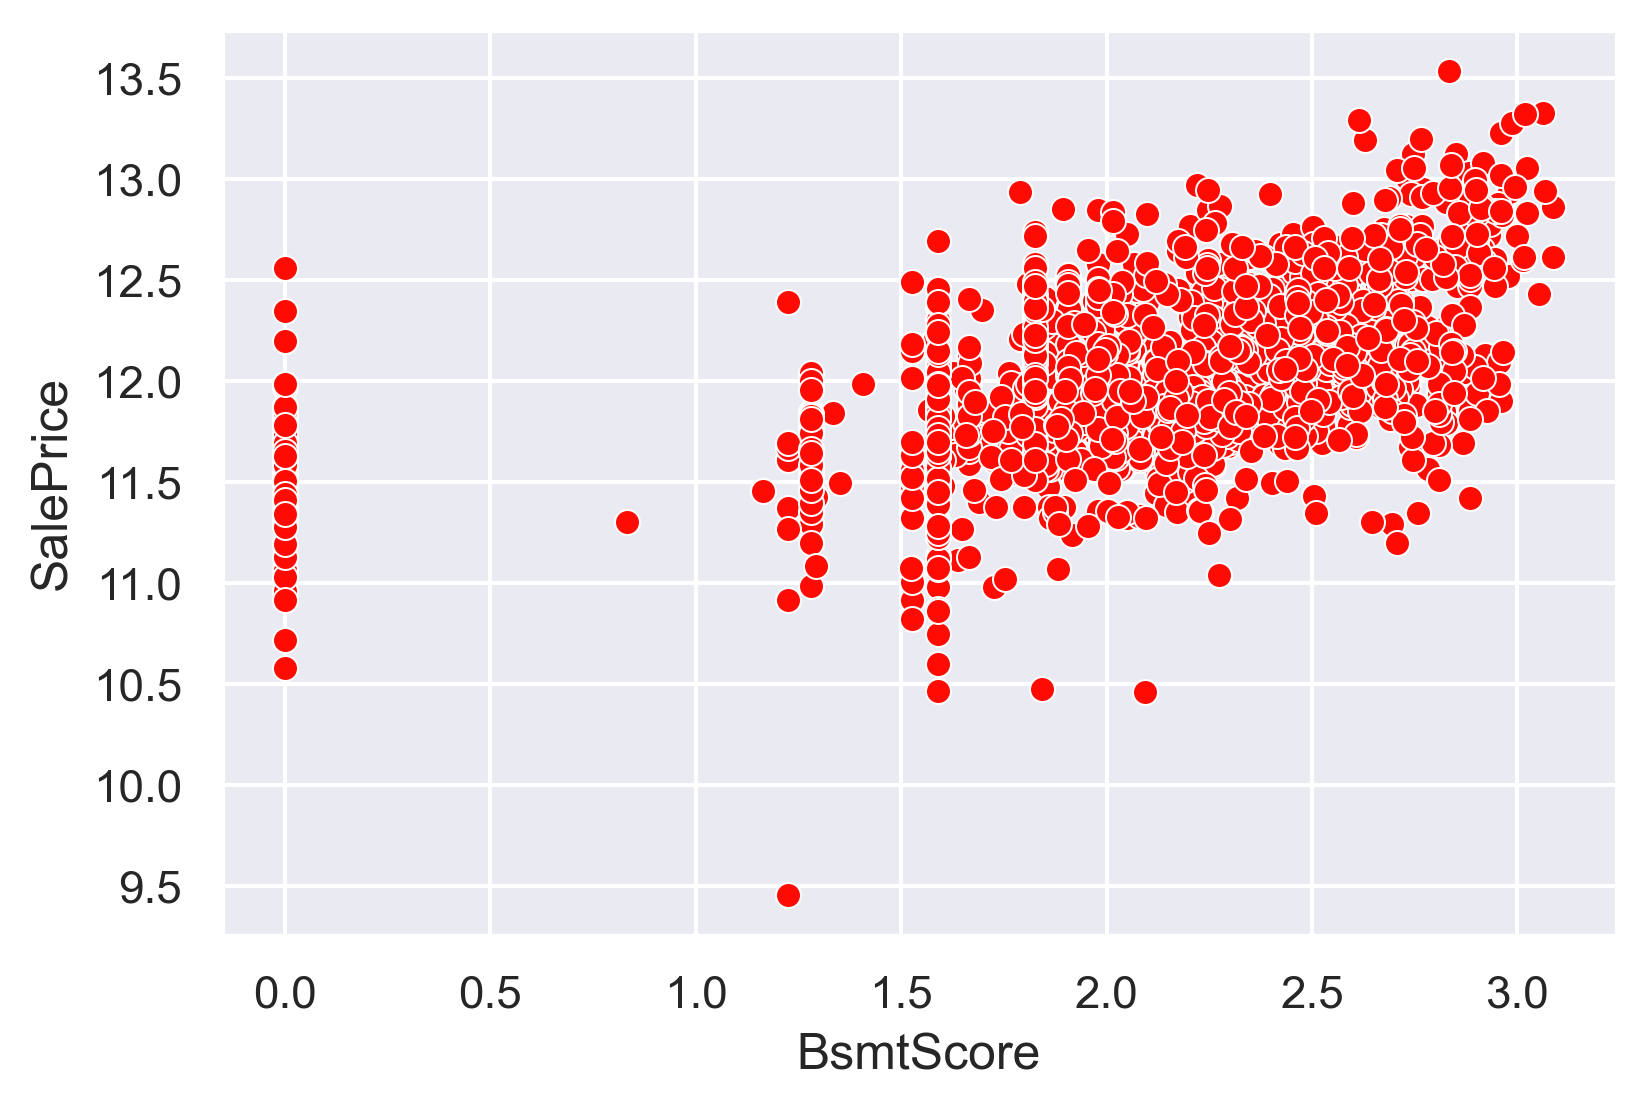

In [57]:
x = np.log(1+hous_trn['BsmtScore'])
y = np.log(hous_trn['SalePrice'])
sns.scatterplot(x=x, y=y)
plt.show()

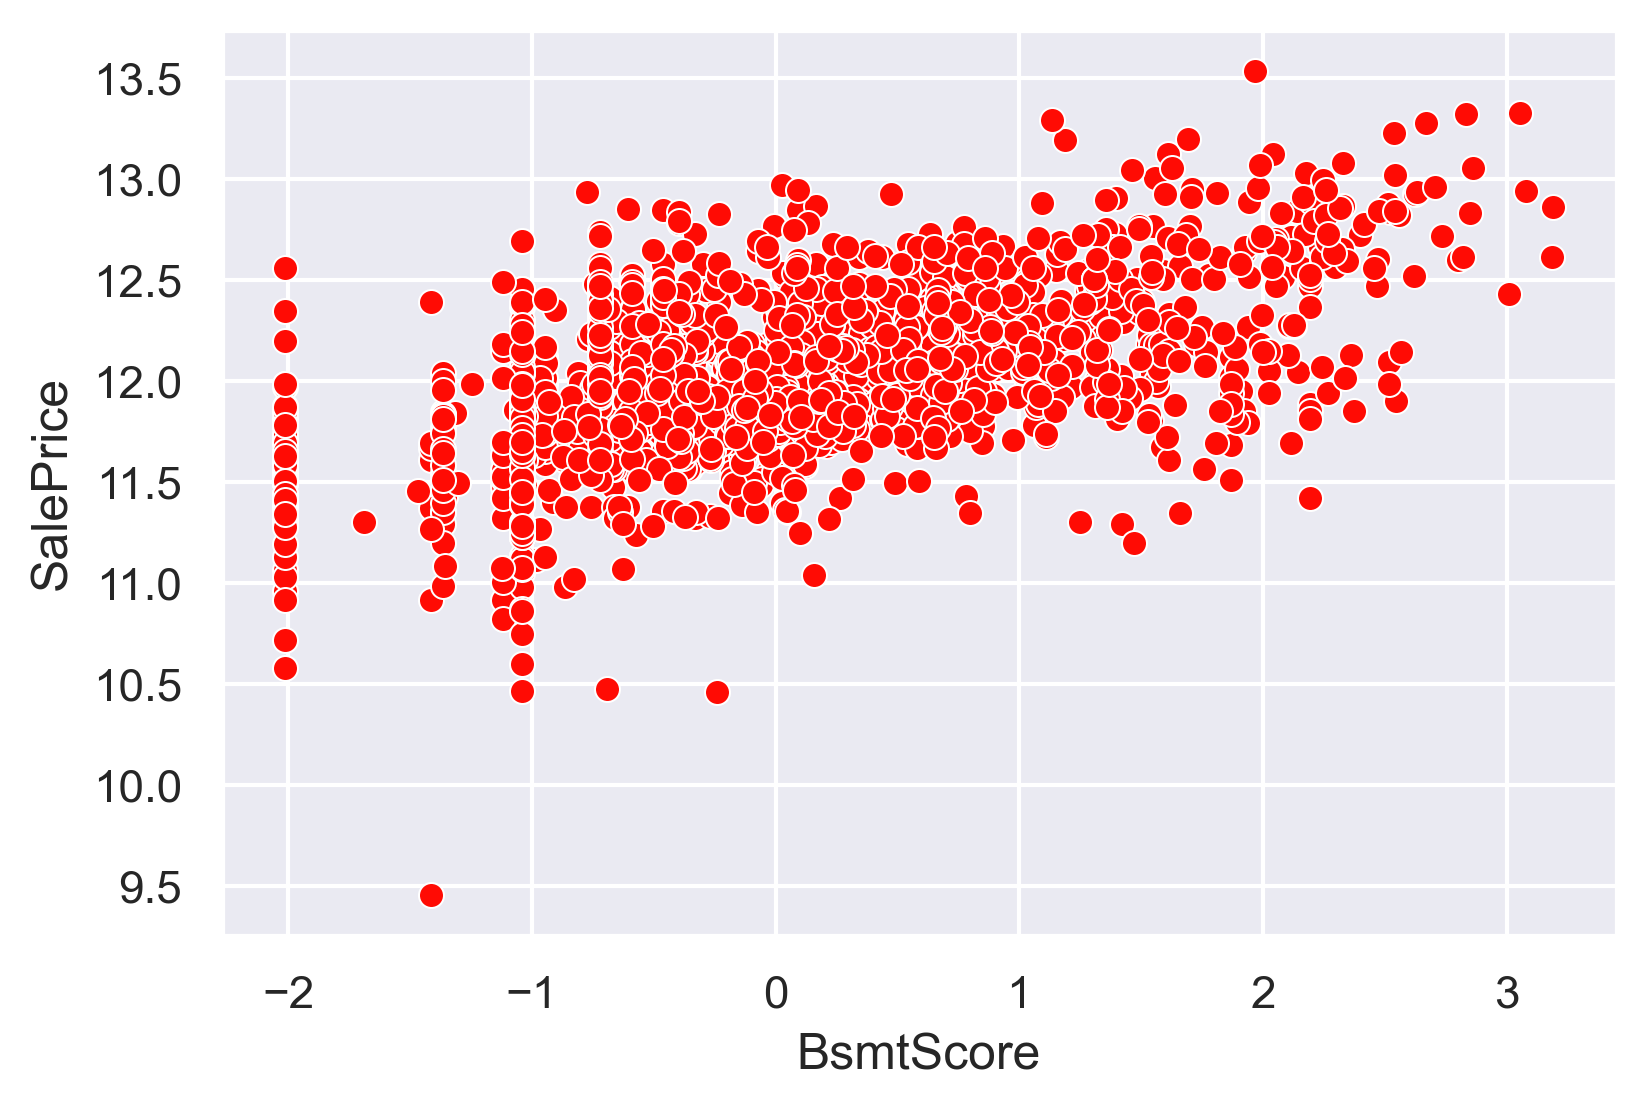

In [58]:
x = (hous_trn['BsmtScore']-np.mean(hous_trn['BsmtScore']))/np.std(hous_trn['BsmtScore'])
y = np.log(hous_trn['SalePrice'])
sns.scatterplot(x=x, y=y)
plt.show()

In [59]:
hous_trn['BsmtScore'] = (hous_trn['BsmtScore']-np.mean(hous_trn['BsmtScore']))/np.std(hous_trn['BsmtScore'])
hous_trn['BsmtSize'] = (hous_trn['TotalBsmtSF']-np.mean(hous_trn['TotalBsmtSF']))/np.std(hous_trn['TotalBsmtSF'])

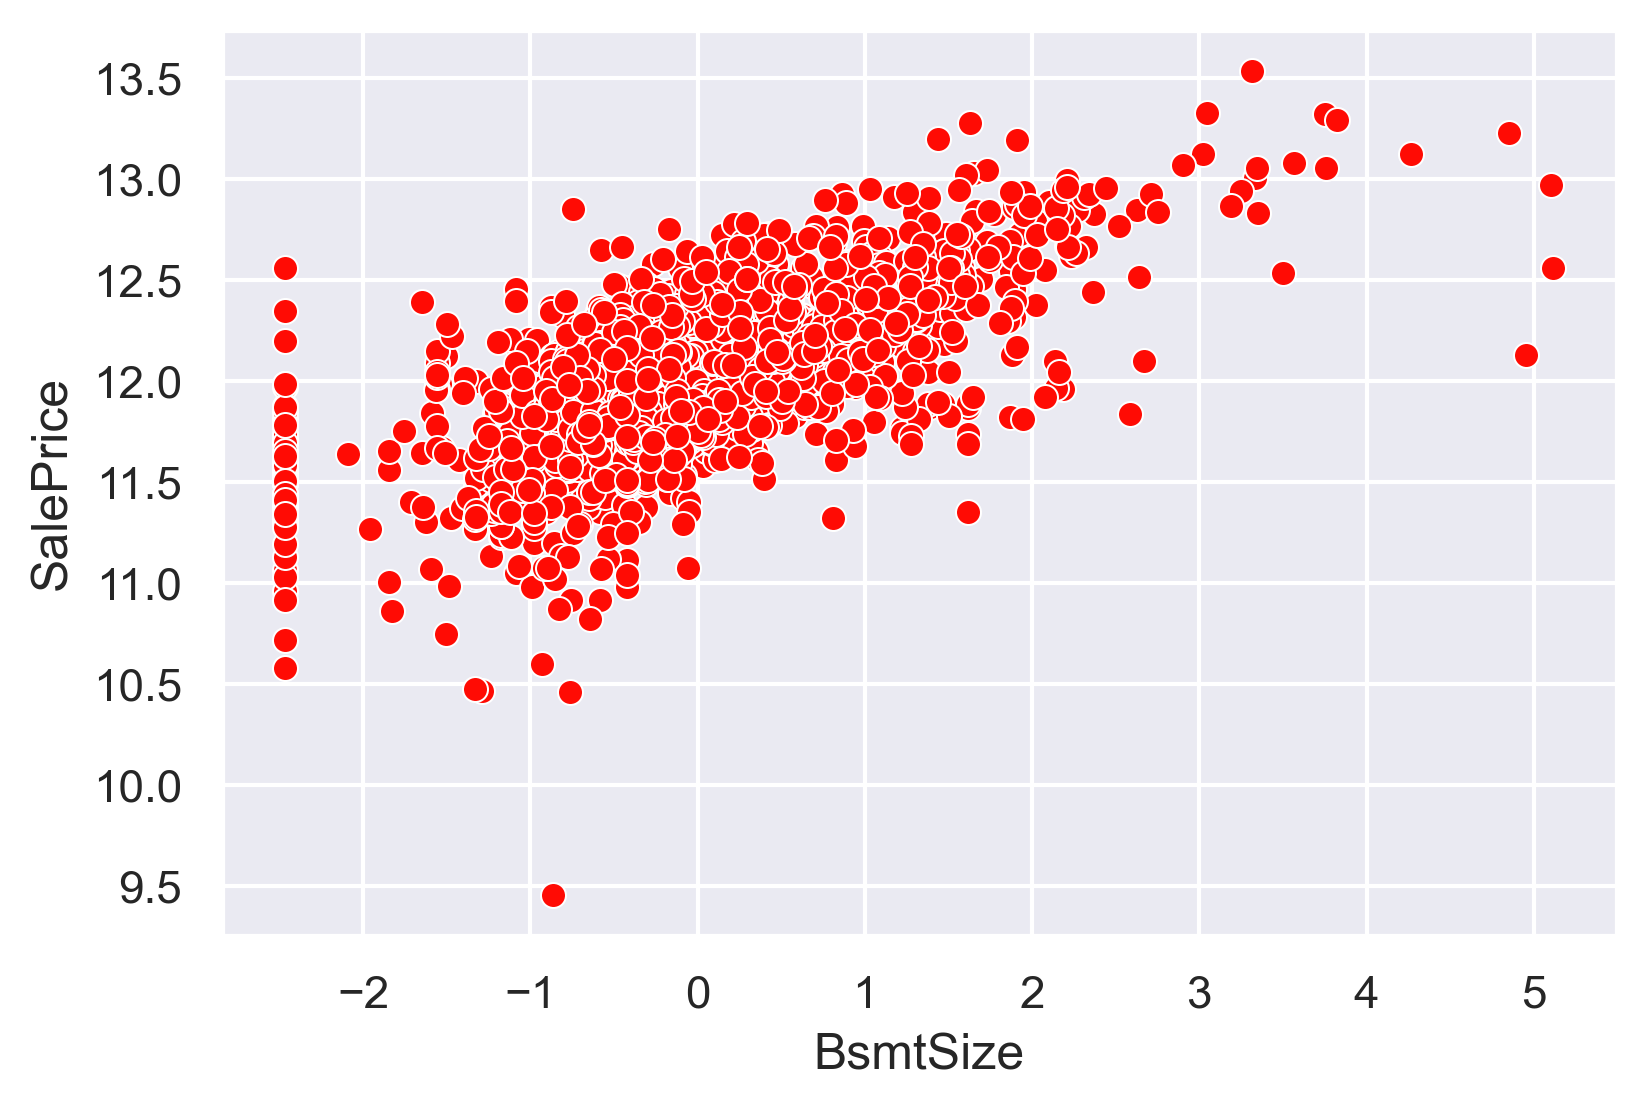

In [60]:
x = hous_trn['BsmtSize']
y = np.log(hous_trn['SalePrice'])
sns.scatterplot(x=x, y=y)
plt.show()

In [61]:
X = hous_trn.loc[:, ['BsmtScore', 'BsmtSize']]
y = np.log(hous_trn['SalePrice'])
reg.fit(X, y)
reg.score(X, y)

0.4894731721035621

In [62]:
hous_trn['BsmtInt'] = hous_trn['BsmtScore']*hous_trn['BsmtSize']

In [63]:
X = hous_trn.loc[:, ['BsmtScore', 'BsmtSize', 'BsmtInt']]
y = np.log(hous_trn['SalePrice'])
reg.fit(X, y)
reg.score(X, y)

0.4996028245953327

In [64]:
hous_trn['BsmtScore2'] = hous_trn['BsmtScore']**2
hous_trn['BsmtSize2'] = hous_trn['BsmtSize']**2

In [65]:
X = hous_trn.loc[:, ['BsmtScore', 'BsmtSize', 'BsmtScore2', 'BsmtSize2', 'BsmtInt']]
y = np.log(hous_trn['SalePrice'])
reg.fit(X, y)
reg.score(X, y)

0.5014952232062034

In [66]:
X = hous_trn.loc[:, ['BsmtScore']]
y = np.log(hous_trn['SalePrice'])
reg.fit(X, y)
reg.score(X, y)

0.29006790171229446

In [67]:
X = hous_trn.loc[:, ['BsmtSize']]
y = np.log(hous_trn['SalePrice'])
reg.fit(X, y)
reg.score(X, y)

0.42205246511801964

In [68]:
X = hous_trn.loc[:, ['BsmtSize', 'BsmtSize2']]
y = np.log(hous_trn['SalePrice'])
reg.fit(X, y)
reg.score(X, y)

0.4229617875410113

In [69]:
X = np.log(1+hous_trn.loc[:, ['TotalBsmtSF']])
y = np.log(hous_trn['SalePrice'])
reg.fit(X, y)
reg.score(X, y)

0.141979792582814

In [70]:
hous_trn = hous_trn.fillna(value={'BsmtFullBath':0, 'BsmtHalfBath':0})

In [71]:
hous_trn['BsmtBathScore'] = stats.zscore(1*hous_trn['BsmtFullBath'] + (1/2)*hous_trn['BsmtHalfBath'])

In [72]:
X = hous_trn.loc[:, ['BsmtScore', 'BsmtSize', 'BsmtScore2', 'BsmtSize2', 'BsmtInt', 'BsmtBathScore']]
y = np.log(hous_trn['SalePrice'])
reg.fit(X, y)
reg.score(X, y)

0.5144867999703528

In [73]:
X = hous_trn.loc[:, ['BsmtScore', 'BsmtSize', 'BsmtScore2', 'BsmtSize2', 'BsmtInt', 'BsmtFullBath', 'BsmtHalfBath']]
y = np.log(hous_trn['SalePrice'])
reg.fit(X, y)
reg.score(X, y)

0.5159862041802974

In [74]:
X = hous_trn.loc[:, ['BsmtScore', 'BsmtSize', 'BsmtInt', 'BsmtBathScore']]
y = np.log(hous_trn['SalePrice'])
reg.fit(X, y)
reg.score(X, y)

0.511233189724658

In [75]:
X = hous_trn.loc[:, ['BsmtScore', 'BsmtSize', 'BsmtInt', 'BsmtFullBath', 'BsmtHalfBath']]
y = np.log(hous_trn['SalePrice'])
reg.fit(X, y)
reg.score(X, y)

0.5127109917311263

In [76]:
X = hous_trn.loc[:, ['BsmtScore', 'BsmtSize', 'BsmtBathScore']]
y = np.log(hous_trn['SalePrice'])
reg.fit(X, y)
reg.score(X, y)

0.5002625286618914

In [77]:
LotFront = hous_trn['LotFrontage']
LotArea = hous_trn['LotArea']

new_col = []
for i in range(len(hous_trn)):
    if np.isnan(LotFront[i]):
        new_col.append(np.sqrt(LotArea[i]/3))
    else:
        new_col.append(LotFront[i])
    
hous_trn['LotFrontage'] = new_col

In [78]:
hous_trn['LotFrontage'] = stats.zscore(hous_trn['LotFrontage'])

In [79]:
hous_trn['LotArea'] = stats.zscore(hous_trn['LotArea'])

In [80]:
X = hous_trn.loc[:, ['LotFrontage']]
y = np.log(hous_trn['SalePrice'])
reg.fit(X, y)
reg.score(X, y)

0.09544842700017087

In [81]:
X = hous_trn.loc[:, ['LotArea']]
y = np.log(hous_trn['SalePrice'])
reg.fit(X, y)
reg.score(X, y)

0.09334347926123265

In [82]:
X = hous_trn.loc[:, ['LotFrontage', 'LotArea']]
y = np.log(hous_trn['SalePrice'])
reg.fit(X, y)
reg.score(X, y)

0.1207468552447225

In [83]:
X = hous_trn.loc[:, ['BsmtScore', 'BsmtSize', 'BsmtBathScore', 'LotFrontage', 'LotArea']]
y = np.log(hous_trn['SalePrice'])
reg.fit(X, y)
reg.score(X, y)


0.5284709131052713

In [97]:
X = hous_trn.loc[:, ['BsmtScore', 'BsmtSize', 'BsmtBathScore', 'LotFrontage', 'LotArea', 'Neighborhood']]
transformer = ColumnTransformer([("Cat", OneHotEncoder(drop='first'), ['Neighborhood'])], remainder='passthrough', sparse_threshold=0)
X = transformer.fit_transform(X)
rename_dict = dict(zip(pd.DataFrame(X).columns, transformer.get_feature_names()))
X = pd.DataFrame(X).rename(columns=rename_dict)
pd.DataFrame(X).head()

Cat__x0_Blueste  Cat__x0_BrDale  Cat__x0_BrkSide  Cat__x0_ClearCr  \
0              0.0             0.0              0.0              0.0   
1              0.0             1.0              0.0              0.0   
2              0.0             0.0              0.0              0.0   
3              0.0             0.0              0.0              0.0   
4              0.0             0.0              0.0              0.0   

   Cat__x0_CollgCr  Cat__x0_Crawfor  Cat__x0_Edwards  Cat__x0_Gilbert  \
0              0.0              0.0              0.0              0.0   
1              0.0              0.0              0.0              0.0   
2              0.0              1.0              0.0              0.0   
3              0.0              0.0              0.0              0.0   
4              0.0              0.0              0.0              0.0   

   Cat__x0_Greens  Cat__x0_GrnHill  ...  Cat__x0_SawyerW  Cat__x0_Somerst  \
0             0.0              0.0  ...              0.0              0.0   
1             0.0              0.0  ...              0.0              0.0   
2             0.0              0.0  ...              0.0              0.0   
3             0.0              0.0  ...              0.0              0.0   
4             0.0              0.0  ...              0.0              0.0   

   Cat__x0_StoneBr  Cat__x0_Timber  Cat__x0_Veenker  BsmtScore  BsmtSize  \
0              0.0             0.0              0.0   0.164112  0.256562   
1              0.0             0.0              0.0  -0.030092 -1.326100   
2              0.0             0.0              0.0   0.191199 -0.036787   
3              0.0             0.0              0.0  -0.177910 -0.311209   
4              0.0             0.0              0.0   0.452880  0.150105   

   BsmtBathScore  LotFrontage   LotArea  
0      -0.922486     1.151933  0.286524  
1       0.046575    -2.097862 -1.384688  
2       1.015636    -0.266992 -0.460085  
3       1.015636    -0.670590 -0.309272  
4      -0.922486     0.373813  0.014894  

[5 rows x 32 columns]

In [98]:
X = hous_trn.loc[:, ['BsmtScore', 'BsmtSize', 'BsmtBathScore', 'LotFrontage', 'LotArea', 'Neighborhood']]
transformer = ColumnTransformer([("Cat", OneHotEncoder(drop='first'), ['Neighborhood'])], remainder='passthrough')
X = transformer.fit_transform(X)
y = np.log(hous_trn['SalePrice'])
reg.fit(X, y)
reg.score(X, y)

0.7085556547084725

In [99]:
X = hous_trn.loc[:, ['BsmtScore', 'BsmtSize', 'BsmtBathScore', 'LotFrontage', 'LotArea', 'BedroomAbvGr','Neighborhood']]
transformer = ColumnTransformer([("Cat", OneHotEncoder(drop='first'), ['Neighborhood'])], remainder='passthrough')
X = transformer.fit_transform(X)
y = np.log(hous_trn['SalePrice'])
reg.fit(X, y)
reg.score(X, y)

0.7413289050048171

In [111]:
X = hous_trn.loc[:, ['BsmtScore', 'BsmtSize', 'BsmtBathScore', 'LotFrontage', 'LotArea', 'BedroomAbvGr', 'Neighborhood']]
transformer = ColumnTransformer([("Cat", OneHotEncoder(drop='first'), ['BedroomAbvGr','Neighborhood'])], remainder='passthrough')
X = transformer.fit_transform(X)
y = np.log(hous_trn['SalePrice'])
reg.fit(X, y)
reg.score(X, y)

0.7462388204139626